
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [1]:
from __future__ import division

import warnings


from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
from scipy import stats

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.


In [2]:
import chart_studio
chart_studio.tools.set_credentials_file(username='ffftelias', api_key='••••••••••')

import chart_studio.plotly as py
import plotly.graph_objects as go

In [3]:
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

import ruptures as rpt

In [5]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.6f}'.format

# Función Productividad de pozos

In [23]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    global vector
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                               'expon',
                               'gamma',
                               'lognorm',
                               'norm',
                               'pearson3',
                               'triang',
                               'uniform',
                               'weibull_min', 
                               'weibull_max',
                               'alpha',             
                               'anglit',            
                               'arcsine',           
                               'argus',                       
                               'betaprime',         
                               'bradford',          
                               'burr',              
                               'burr12',            
                               'cauchy',            
                               'chi',               
                               'chi2',              
                               'cosine',            
                               'crystalball',       
                               'dgamma',            
                               'dweibull',          
                               'erlang',            
                               'exponnorm',         
                               'exponweib',         
                               'exponpow',          
                               'f',                 
                               'fatiguelife',       
                               'fisk',              
                               'foldcauchy',        
                               'foldnorm',          
                               'frechet_r',         
                               'frechet_l',         
                               'genlogistic',       
                               'gennorm',           
                               'genpareto',         
                               'genexpon',          
                               'genextreme',        
                               'gausshyper',             
                               'gengamma',          
                               'genhalflogistic',   
                               'gilbrat',           
                               'gompertz',          
                               'gumbel_r',          
                               'gumbel_l',          
                               'halfcauchy',        
                               'halflogistic',      
                               'halfnorm',          
                               'halfgennorm',       
                               'hypsecant',         
                               'invgamma',          
                               'invgauss',          
                               'invweibull',        
                               'johnsonsb',         
                               'johnsonsu',         
                               'kappa4',            
                               'kappa3',            
                               'ksone',             
                               'kstwobign',         
                               'laplace',           
                               'levy',              
                               'levy_l',
                               'levy_stable',
                               'logistic',          
                               'loggamma',          
                               'loglaplace',                  
                               'lomax',             
                               'maxwell',           
                               'mielke',            
                               'moyal',             
                               'nakagami',          
                               'ncx2',              
                               'ncf',               
                               'nct',                
                               'norminvgauss',      
                               'pareto',          
                               'powerlaw',          
                               'powerlognorm',      
                               'powernorm',         
                               'rdist',             
                               'reciprocal',        
                               'rayleigh',          
                               'rice',              
                               'recipinvgauss',     
                               'semicircular',      
                               'skewnorm',          
                               't',                 
                               'trapz',                        
                               'truncexpon',        
                               'truncnorm',         
                               'tukeylambda',           
                               'vonmises',          
                               'vonmises_line',     
                               'wald',       
                               'wrapcauchy']
            
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                         #index_col=1,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    vector=pd.DataFrame()
    gasto=pd.DataFrame()
    
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 24, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        production_time_series.loc[:,'month']=(production_time_series['aceite_Mbd'] > 0).cumsum()
        
        gasto=[[pozo,qi]]
        display(gasto)

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='month'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
        vector=vector.append(gasto,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    vector=vector.rename(columns={0:'pozo',1:'qi'}).set_index('pozo')
    vector.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    #results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.month,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('month')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

# Productividad 2

In [34]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    global vector
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                               'expon',
                               'gamma',
                               'lognorm',
                               'norm',
                               'pearson3',
                               'triang',
                               'uniform',
                               'weibull_min', 
                               'weibull_max']
            
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_bd.csv',
                         #index_col=1,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #dst.Fit(campo.aceite_Mbd)
    #dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    vector=pd.DataFrame()
    gasto=pd.DataFrame()
    
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 24, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        production_time_series.loc[:,'month']=(production_time_series['aceite_Mbd'] > 0).cumsum()
        
        gasto=[[pozo,qi]]
        display(gasto)

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='month'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
        vector=vector.append(gasto,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    vector=vector.rename(columns={0:'pozo',1:'qi'}).set_index('pozo')
    vector.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    #results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.month,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('month')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

'Numero de datos en BD: 2851710'

Nombre de Campo: ARENQUE


'Numero de datos para ARENQUE: 9822'

'Número de pozos en ARENQUE: 43'

array(['ARENQUE-6', 'ARENQUE-5', 'ARENQUE-13A', 'ARENQUE-16',
       'ARENQUE-18', 'ARENQUE-15', 'ARENQUE-22', 'ARENQUE-23',
       'ARENQUE-17', 'ARENQUE-24', 'ARENQUE-30', 'ARENQUE-31',
       'ARENQUE-10', 'ARENQUE-28', 'ARENQUE-37', 'ARENQUE-42',
       'ARENQUE-103', 'ARENQUE-104', 'ARENQUE-46', 'ARENQUE-20',
       'ARENQUE-48', 'ARENQUE-12', 'ARENQUE-50', 'ARENQUE-101',
       'ARENQUE-33', 'ARENQUE-26', 'ARENQUE-54', 'ARENQUE-56',
       'ARENQUE-58', 'ARENQUE-41', 'ARENQUE-1', 'ARENQUE-2', 'ARENQUE-4',
       'ARENQUE-7', 'ARENQUE-9', 'ARENQUE-13', 'ARENQUE-14',
       'ARENQUE-102', 'ARENQUE-17H', 'ARENQUE-23H', 'ARENQUE-310',
       'ARENQUE-37D', 'ARENQUE-41D'], dtype=object)

'Percentiles y estadistica descriptiva: '

0.100000   0.075478
0.500000   0.297529
0.900000   1.082366
Name: aceite_Mbd, dtype: float64

Unnamed: 0   aceite_Mbd     agua_Mbd  condensado_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd  ano_de_perforacion            GID  profundidad_total  profundidad_vertical
count   9,809.000000 9,809.000000 9,809.000000    9,809.000000        9,809.000000           9,809.000000        9,822.000000   9,822.000000       9,822.000000          9,820.000000
mean  412,593.205526     0.507396     0.088924        0.000000            1.440876               0.001536        1,974.349521 126,936.551008       3,834.619019          3,442.701833
std   237,992.647298     0.643799     0.159580        0.000000            1.625283               0.026308            2.722271   7,051.070792         257.414305             85.953397
min     1,366.000000     0.000000     0.000000        0.000000            0.000000               0.000000        1,966.000000 115,521.000000       3,421.000000          3,215.000000
25%   208,647.000000     0.145274     0.003667        0.000000            0.257341               0.000000        1,972.000000 124,610.000000       3,640.000000          3,403.000000
50%   354,222.000000     0.297529     0.018869        0.000000            0.751908               0.000000        1,974.000000 127,255.000000       3,770.000000          3,427.000000
75%   592,707.000000     0.641560     0.107937        0.000000            2.199224               0.000000        1,977.000000 133,174.000000       3,950.000000          3,438.000000
max   997,317.000000     6.590899     1.284582        0.000000           10.632659               0.658457        2,014.000000 211,446.000000       4,633.000000          3,870.000000

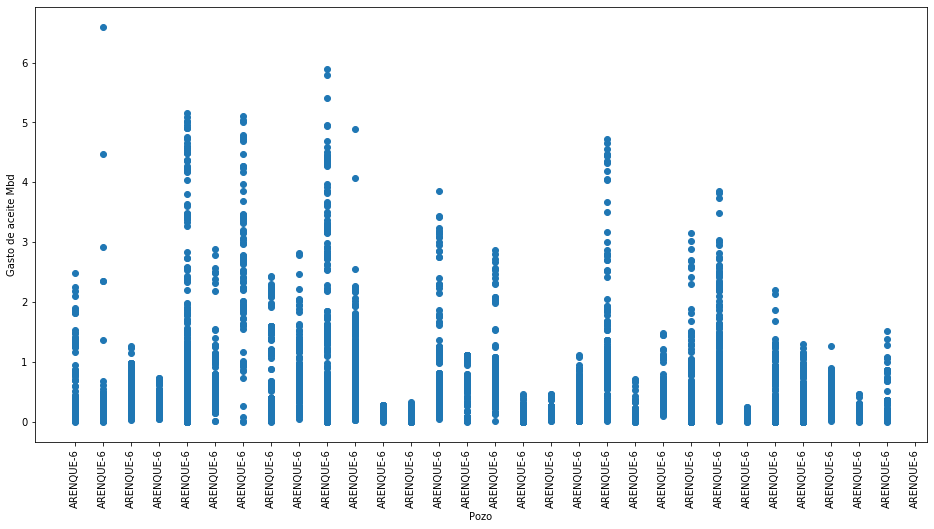

Exponential Fit Curve-fitted Variables: qi=0.8619120046990145, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.9650709862481195, b=0.9517338829955942, di=0.0012958960347700535
Harmonic Fit Curve-fitted Variables: qi=1.9821895648577215, di=0.0013721022708107927


[['ARENQUE-6', 2.478406]]

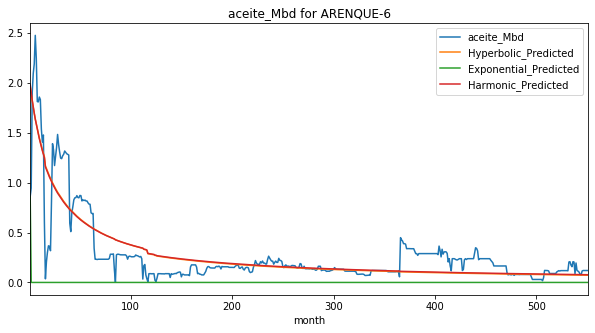

Exponential Fit Curve-fitted Variables: qi=2.346298005261593, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.6082342609281945, b=0.8769598984865918, di=0.0037592407661391327
Harmonic Fit Curve-fitted Variables: qi=2.6301285704393385, di=0.004299111560515916


[['ARENQUE-5', 6.590899]]

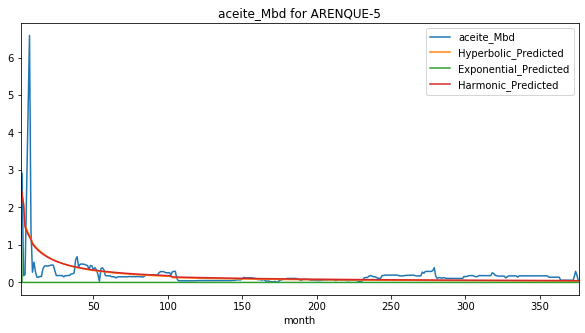

Exponential Fit Curve-fitted Variables: qi=0.35202600012100954, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.4876520003960175, b=1.999999999999827, di=2.4169500314780594e-17
Harmonic Fit Curve-fitted Variables: qi=0.48765199989280184, di=4.55930524117563e-18


[['ARENQUE-13A', 0.9465129999999999]]

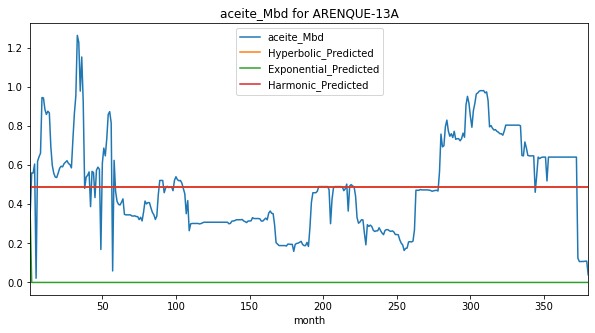

Exponential Fit Curve-fitted Variables: qi=0.4208079203436799, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.7038756631111026, b=2.065495819845955e-07, di=0.0004642189088281963
Harmonic Fit Curve-fitted Variables: qi=0.7318489999999999, di=0.0008049482262915288


[['ARENQUE-16', 0.731849]]

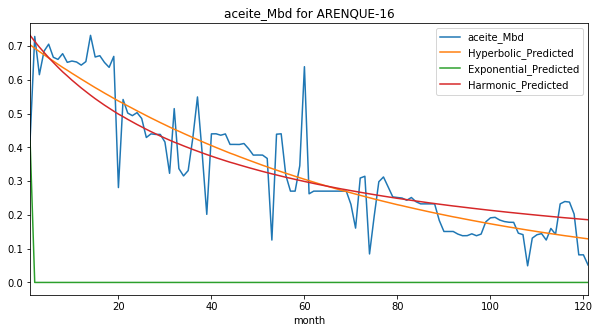

Exponential Fit Curve-fitted Variables: qi=0.2215652588621344, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.7054201381711565, b=0.6310239355251599, di=0.0005593431086941982
Harmonic Fit Curve-fitted Variables: qi=4.795376280273978, di=0.0007383393884017615


[['ARENQUE-18', 5.159805]]

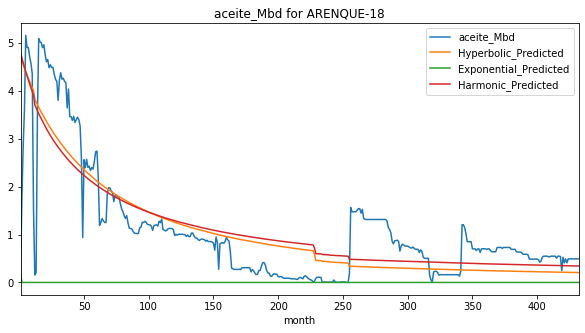

Exponential Fit Curve-fitted Variables: qi=0.3908350000668773, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.4100825150064196, b=0.9336165235430246, di=0.00044423332354268335
Harmonic Fit Curve-fitted Variables: qi=1.4194444902068404, di=0.00046767426969295965


[['ARENQUE-15', 1.548508]]

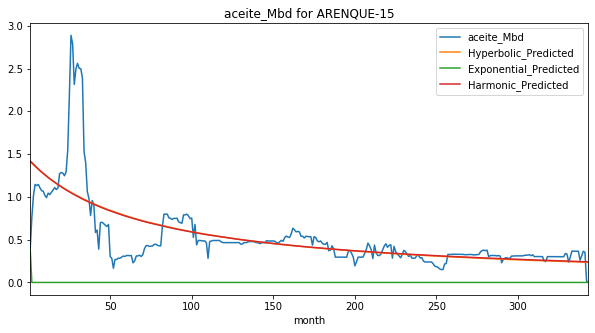

Exponential Fit Curve-fitted Variables: qi=1.0150930931914515, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.9212301543025414, b=6.413549025729785e-12, di=0.0003271215598235116
Harmonic Fit Curve-fitted Variables: qi=3.942827019618268, di=0.0004338834273976111


[['ARENQUE-22', 5.109751999999999]]

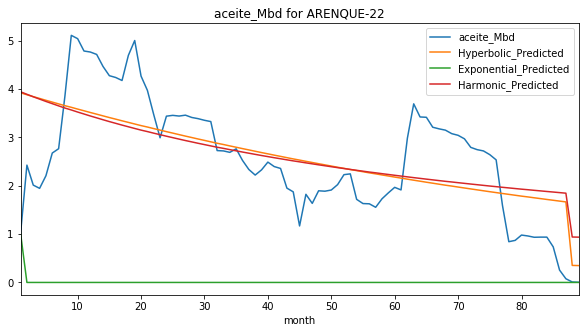

Exponential Fit Curve-fitted Variables: qi=0.1489370538819828, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.0291934888677927, b=7.135752871616285e-07, di=2.177754336070664e-05
Harmonic Fit Curve-fitted Variables: qi=0.9470451442443468, di=1.689054213485872e-05


[['ARENQUE-23', 2.1574009999999997]]

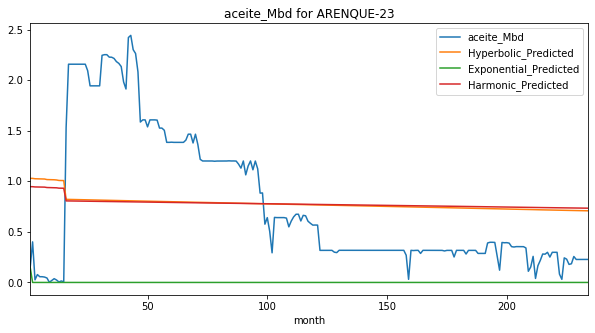

Exponential Fit Curve-fitted Variables: qi=0.5135322584897346, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.9877808406602084, b=1.3505804246715876, di=0.0010498842015479242
Harmonic Fit Curve-fitted Variables: qi=1.9018985015533358, di=0.0007520239768740857


[['ARENQUE-17', 2.818504]]

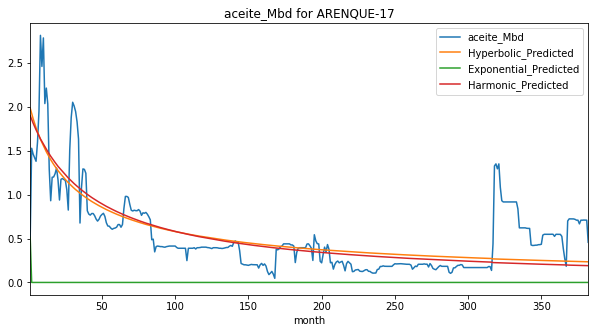

Exponential Fit Curve-fitted Variables: qi=0.012740028847006453, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.1573973057255404, b=0.3176747728830819, di=0.0005603987067470912
Harmonic Fit Curve-fitted Variables: qi=5.7277518780184336, di=0.0011119397071500821


[['ARENQUE-24', 5.898574]]

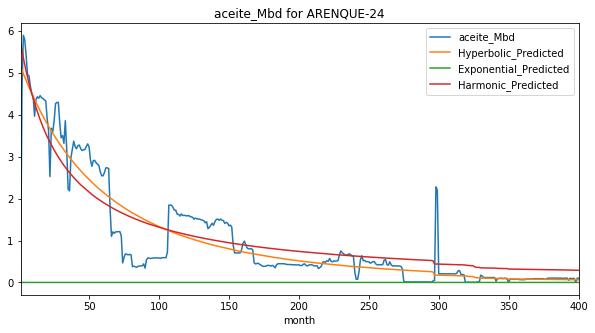

Exponential Fit Curve-fitted Variables: qi=0.5995600090661387, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.7822625364829658, b=0.4420976793962939, di=0.00013439689769099563
Harmonic Fit Curve-fitted Variables: qi=1.888900428742599, di=0.00019725641178806535


[['ARENQUE-30', 4.889481]]

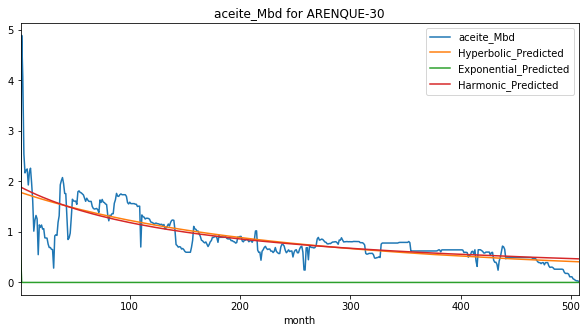

Exponential Fit Curve-fitted Variables: qi=0.007715654776147625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.15420973892909837, b=3.873935128313517e-14, di=8.242244799173955e-06
Harmonic Fit Curve-fitted Variables: qi=0.15043817887609165, di=6.270925932400407e-06


[['ARENQUE-31', 0.281213]]

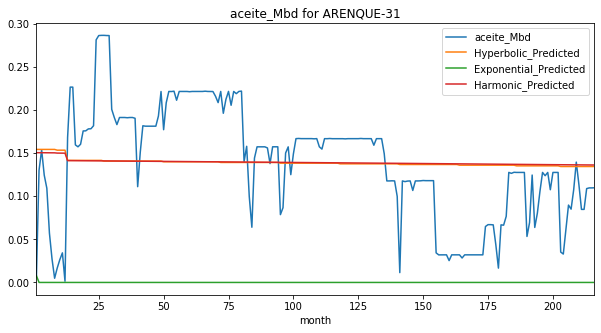

Exponential Fit Curve-fitted Variables: qi=0.11341900058556424, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2018212460120947, b=3.1220595263778546e-08, di=0.0003283461917325089
Harmonic Fit Curve-fitted Variables: qi=0.20229064663577312, di=0.0004506919777697849


[['ARENQUE-10', 0.32564899999999997]]

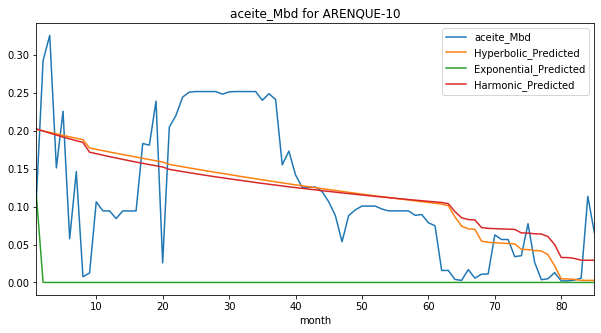

Exponential Fit Curve-fitted Variables: qi=2.746409875392796, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.8630599999964375, b=1.7493622194426406, di=0.0036323076371673766
Harmonic Fit Curve-fitted Variables: qi=3.3949098856530324, di=0.0014533197475866484


[['ARENQUE-28', 3.86306]]

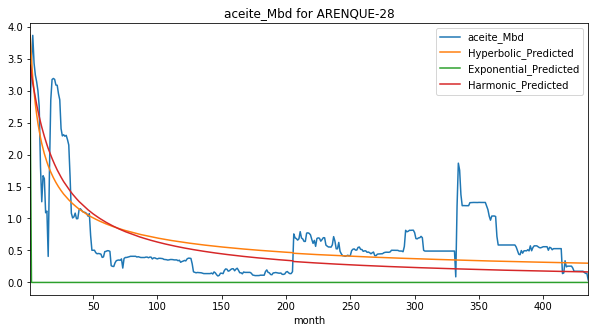

Exponential Fit Curve-fitted Variables: qi=0.0680432265625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.06857899999999999, b=1.9999999999999998, di=2.0606122219558826e-22
Harmonic Fit Curve-fitted Variables: qi=0.06857899999999605, di=2.0419367543675284e-16


[['ARENQUE-37', 0.068579]]

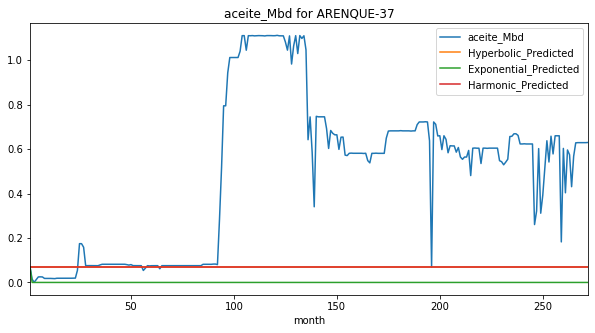

Exponential Fit Curve-fitted Variables: qi=0.39164500053275386, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.1782927916223906, b=1.9999999999999998, di=0.0013209337763566632
Harmonic Fit Curve-fitted Variables: qi=0.781655095759019, di=7.640221982882108e-07


[['ARENQUE-42', 2.867939]]

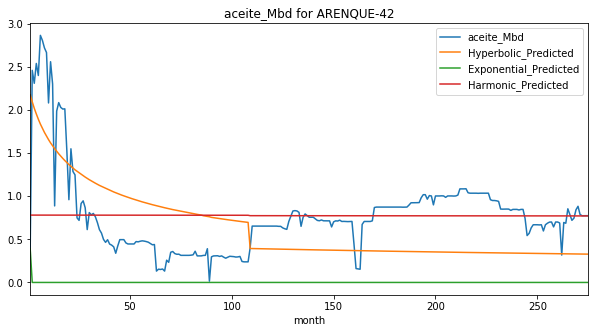

Exponential Fit Curve-fitted Variables: qi=0.003449197228018388, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09549863348797365, b=0.0005583532358828247, di=2.2427728189708846e-17
Harmonic Fit Curve-fitted Variables: qi=0.09549863276744008, di=4.297411900423669e-22


[['ARENQUE-103', 0.18423]]

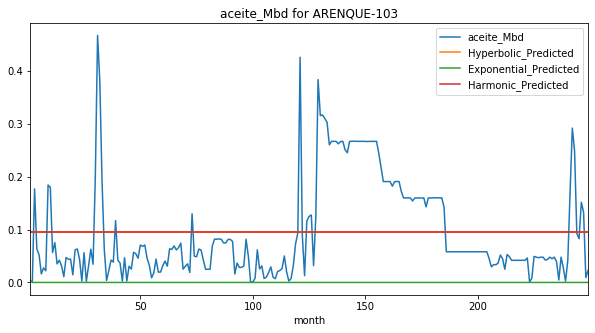

Exponential Fit Curve-fitted Variables: qi=0.1845735562601313, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2512398194224818, b=1.9999999999999998, di=0.00012309395420597973
Harmonic Fit Curve-fitted Variables: qi=0.23304968794993386, di=7.086448958746702e-05


[['ARENQUE-104', 0.463822]]

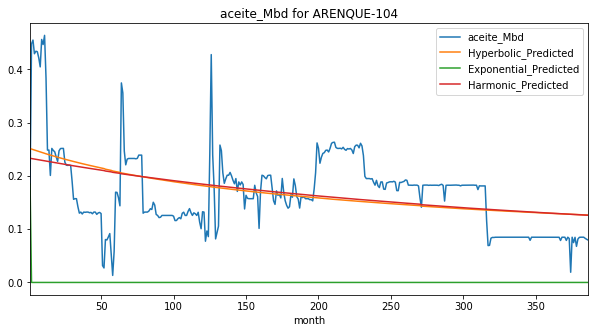

Exponential Fit Curve-fitted Variables: qi=0.47132899999428796, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2989002453446754, b=1.9999999999999998, di=1.2786288803146382e-20
Harmonic Fit Curve-fitted Variables: qi=0.29890024521892755, di=1.7291850412324572e-17


[['ARENQUE-46', 0.903215]]

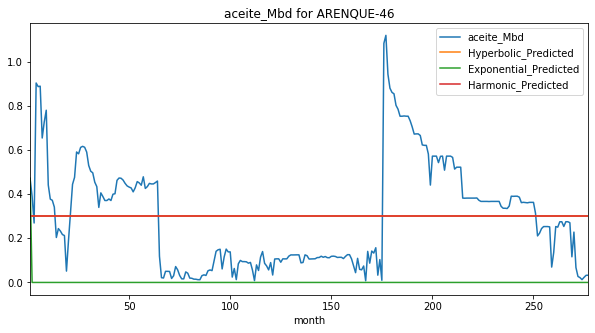

Exponential Fit Curve-fitted Variables: qi=0.8201909451922823, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.132948383515498, b=1.7610519412998524, di=0.0011150522903773928
Harmonic Fit Curve-fitted Variables: qi=3.0311769283443293, di=0.0006387426863156849


[['ARENQUE-20', 4.71735]]

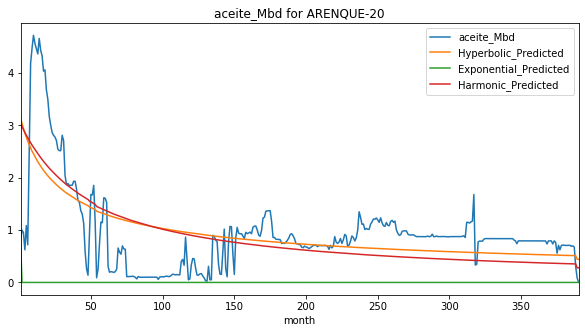

Exponential Fit Curve-fitted Variables: qi=0.13959301626794396, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.42983930950135407, b=1.0540148092581139e-07, di=0.0008710312064480933
Harmonic Fit Curve-fitted Variables: qi=0.4128851887451452, di=0.001034322424619722


[['ARENQUE-48', 0.710747]]

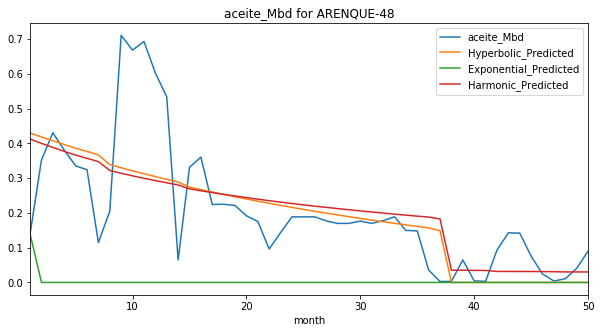

Exponential Fit Curve-fitted Variables: qi=0.47619903121670465, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.2118632361520945, b=1.8861250968470087, di=0.0007524025362913787
Harmonic Fit Curve-fitted Variables: qi=0.9908140713190802, di=0.0002679232918265981


[['ARENQUE-12', 1.4781030000000002]]

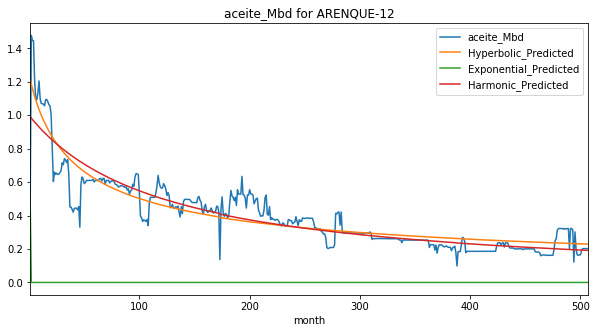

Exponential Fit Curve-fitted Variables: qi=0.4447500002556154, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.4139287720061886, b=1.1466238228773376, di=0.0013343507460169776
Harmonic Fit Curve-fitted Variables: qi=2.3305995416394194, di=0.0010848569639709863


[['ARENQUE-50', 3.1449]]

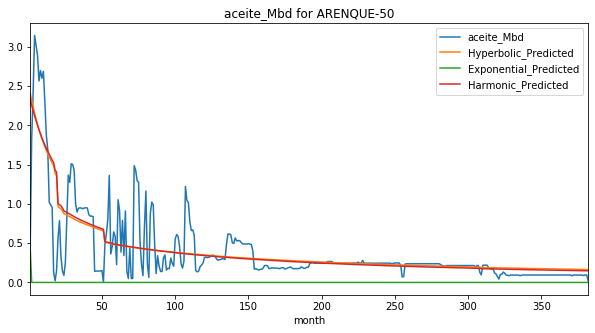

Exponential Fit Curve-fitted Variables: qi=0.022376850341497792, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.991097579424437, b=1.9999999999999518, di=0.001431524562306837
Harmonic Fit Curve-fitted Variables: qi=2.269946757307929, di=0.00037703009903699165


[['ARENQUE-101', 3.8583730000000003]]

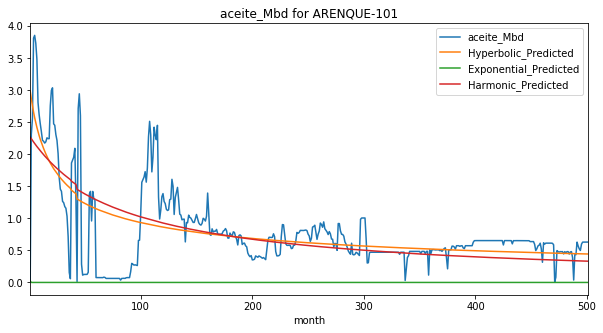

Exponential Fit Curve-fitted Variables: qi=0.01602910701702918, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.05993292000651694, b=0.0030656446781920366, di=1.010226844694294e-15
Harmonic Fit Curve-fitted Variables: qi=0.059932919196385555, di=7.637427164249293e-19


[['ARENQUE-33', 0.188694]]

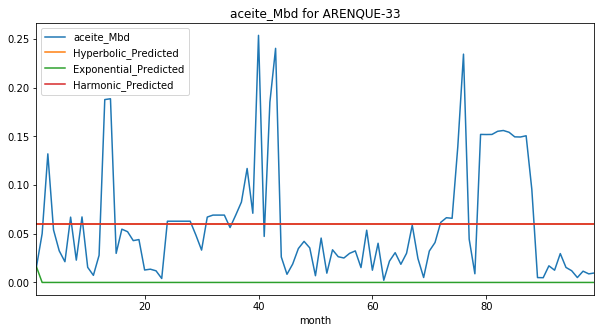

Exponential Fit Curve-fitted Variables: qi=1.3766279997504134, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.836324509451315, b=1.6726203917587315, di=0.0021398971148018434
Harmonic Fit Curve-fitted Variables: qi=1.4340202019979404, di=0.000702295322016076


[['ARENQUE-26', 2.1951400000000003]]

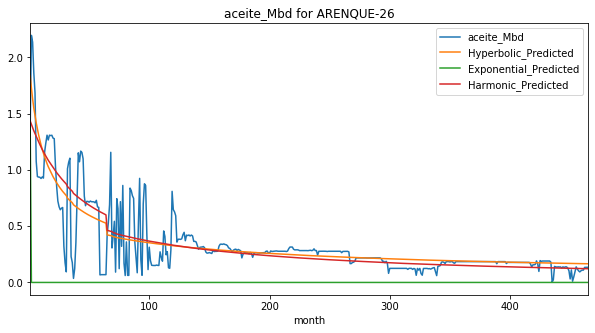

Exponential Fit Curve-fitted Variables: qi=1.0935859152585419, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.2987419999999288, b=1.9999999999999998, di=0.002530521327084955
Harmonic Fit Curve-fitted Variables: qi=1.0217702557896895, di=0.0007021045315479561


[['ARENQUE-54', 1.298742]]

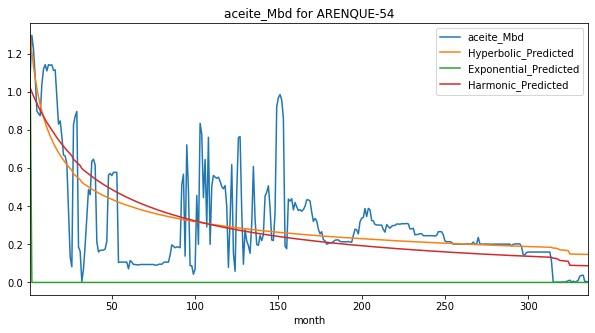

Exponential Fit Curve-fitted Variables: qi=0.2745190032991602, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.4903252295166973, b=1.9999999999999998, di=0.0001838263890080036
Harmonic Fit Curve-fitted Variables: qi=0.38811396842992907, di=5.196222148585075e-05


[['ARENQUE-56', 1.263844]]

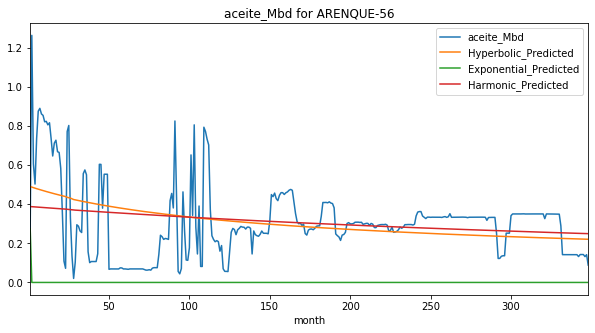

Exponential Fit Curve-fitted Variables: qi=0.2982518059457387, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.19882220336892878, b=0.5040340554576748, di=8.151961536667475e-05
Harmonic Fit Curve-fitted Variables: qi=0.203986256204366, di=0.00010228495140955986


[['ARENQUE-58', 0.299881]]

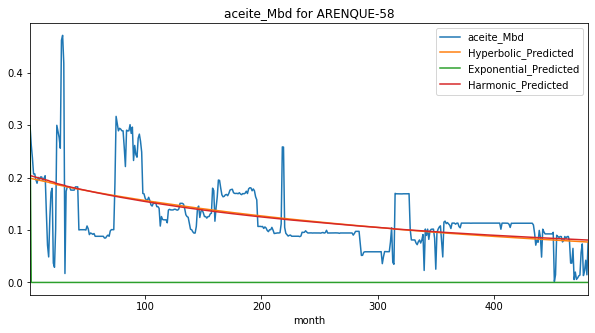

Exponential Fit Curve-fitted Variables: qi=1.0684147280540348, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.374609683945494, b=0.6384490952191818, di=0.002043729101614236
Harmonic Fit Curve-fitted Variables: qi=1.4535694154989434, di=0.0030229337596769774


[['ARENQUE-41', 1.5168620000000002]]

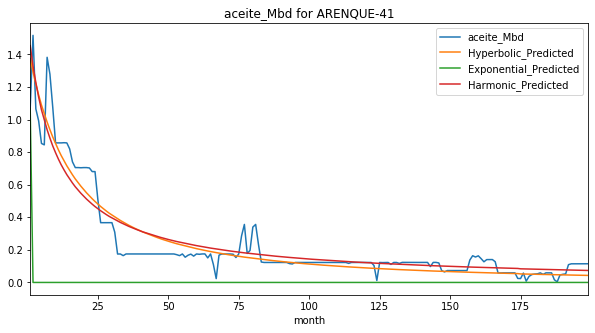

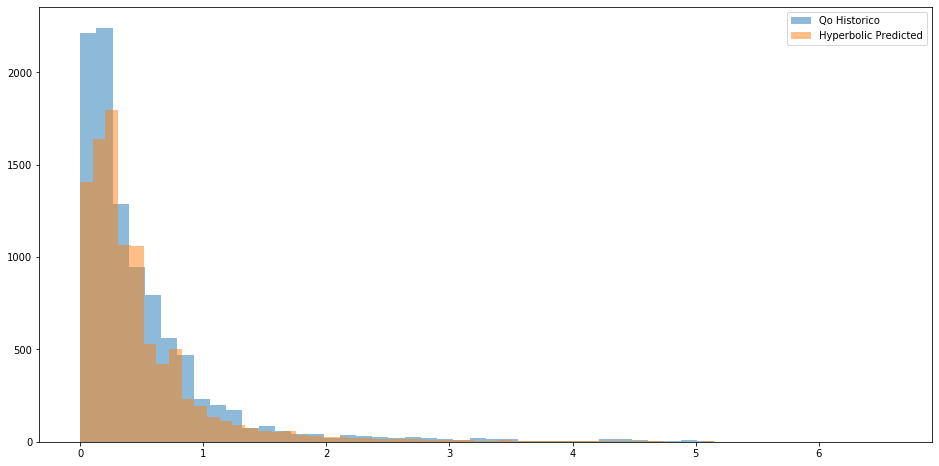

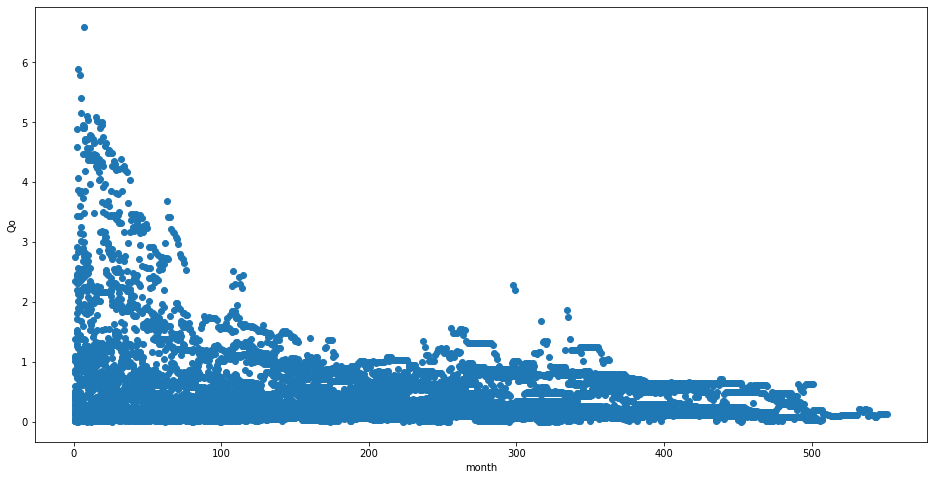

'Tiempo de procesamiento: 36.04662591499999 segundos'

In [35]:
productividad()

In [36]:
periodo=np.arange(start=1,stop=201,step=1)
fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=200,normalize=True,closed='left')

df=pd.DataFrame()

df['date']=fechas
df['month']=pd.DatetimeIndex(fechas).month
df['year']=pd.DatetimeIndex(fechas).year
df['days']=pd.DatetimeIndex(fechas).day
df['periodo']=periodo

display(df.head())

date  month  year  days  periodo
0 2020-01-31      1  2020    31        1
1 2020-02-29      2  2020    29        2
2 2020-03-31      3  2020    31        3
3 2020-04-30      4  2020    30        4
4 2020-05-31      5  2020    31        5

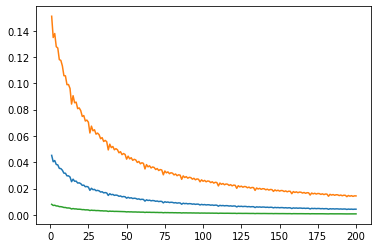

In [75]:
resultado=pd.DataFrame()
gasto=pd.DataFrame()

q10=vector.qi.quantile(.1)
q50=vector.qi.quantile(.5)
q90=vector.qi.quantile(.9)

for x in df:
    gasto['periodo']=df.periodo
    gasto['p10']=(q10/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    gasto['p50']=(q50/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    gasto['p90']=(q90/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000


plt.plot(gasto.periodo,gasto.p50)
plt.plot(gasto.periodo,gasto.p90)
plt.plot(gasto.periodo,gasto.p10)

In [76]:
oil=results[['pozo','aceite_Mbd','month']]

df2=oil.groupby('month').mean().reset_index()

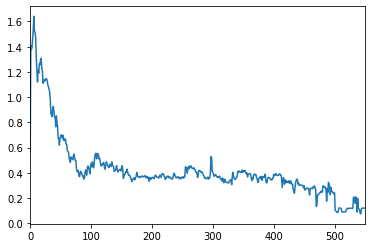

In [77]:
df2.aceite_Mbd.plot()

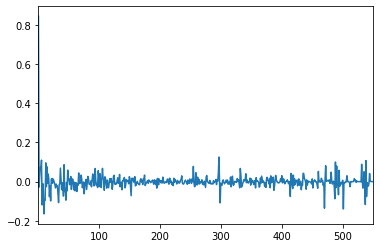

In [78]:
#create a new dataframe to model the difference
df_diff = df2.copy()

#add previous sales to the next row
df_diff['prev_Qo'] = df_diff['aceite_Mbd'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['aceite_Mbd'] - df_diff['prev_Qo']) 
df_diff['diff'].plot()

In [79]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_Qo'],axis=1)
#adding lags
for inc in range(1,51):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [80]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+'
                                +'lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+'
                                +'lag_13+lag_14+lag_15+lag_16+lag_17+'
                                +'lag_18+lag_19+lag_20+lag_21+lag_22+'
                                +'lag_23+lag_24+lag_25+lag_26+lag_27+'
                                +'lag_28+lag_29+lag_30+lag_31+lag_32+'
                                +'lag_33+lag_34+lag_35+lag_36+lag_37+'
                                +'lag_38+lag_39+lag_40+lag_41+lag_42+'
                                +'lag_43+lag_44+lag_45+lag_46+lag_47+'
                                +'lag_48+lag_49+lag_50',
                                data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.05602591795389955


In [81]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['aceite_Mbd','month'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-25].values, df_model[-25:].values

In [82]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [83]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [84]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
475/475 [==============================] - 2s 4ms/step - loss: 0.0378
Epoch 2/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0327
Epoch 3/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0314
Epoch 4/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0303
Epoch 5/100
475/475 [==============================] - 2s 4ms/step - loss: 0.0291
Epoch 6/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0276
Epoch 7/100
475/475 [==============================] - 2s 4ms/step - loss: 0.0261
Epoch 8/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0246
Epoch 9/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0232
Epoch 10/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0218
Epoch 11/100
475/475 [==============================] - 2s 3ms/step - loss: 0.0202
Epoch 12/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 13/100


475/475 [==============================] - 1s 3ms/step - loss: 9.3051e-04
Epoch 99/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 100/100
475/475 [==============================] - 1s 3ms/step - loss: 0.0010


In [85]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [86]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ 0.06209684  0.05210688  0.05210652  0.08195499  0.02220846  0.10878157
   0.09909534  0.16669466  0.0521067   0.0557515   0.04846887  0.05539511
   0.04890486  0.05220142 -0.14339577  0.02542687  0.0408172   0.05337371
   0.05084094  0.27727171  0.10530152  0.01896696  0.02105677  0.01014699
   0.02310914 -1.02880203  0.08914117  0.03837945 -0.05441569  0.00298654
  -0.02948578 -0.14461256  0.47907129 -0.47460392 -0.07831693 -0.07752878
   0.64550565 -0.19626195  0.80291541 -0.63003667 -0.14478184  0.14897464
   0.13932492  0.04889962  0.13199904  0.46833884  0.15332638  0.07192927
   0.19540723  0.15516656 -0.66000191]]
[[-0.1229568   0.04845617  0.05210688  0.05210652  0.08195499  0.02220846
   0.10878157  0.09909534  0.16669466  0.0521067   0.0557515   0.04846887
   0.05539511  0.04890486  0.05220142 -0.14339577  0.02542687  0.0408172
   0.05337371  0.05084094  0.27727171  0.10530152  0.01896696  0.02105677
   0.01014699  0.00904092 -1.02880203  0.08914117  0.03837945 -0.05441569

  -0.32671724  0.02982649 -0.70326172]]
[[ 0.14190254 -0.02169305  0.01197004 -0.52332409  0.86158464 -0.83124868
   0.02661666  0.43215109 -0.07643591 -0.19939509  0.07607773  0.72022499
   0.03732423  0.0521067   0.0521067   0.05577759  0.04845617  0.05210688
   0.05210652  0.08195499  0.02220846  0.10878157  0.09909534  0.16669466
   0.0521067   0.04215336  0.03476586  0.04179184  0.03520812  0.03855216
  -0.15986183  0.01139202  0.027004    0.03974133  0.03717208  0.26686369
   0.09241695  0.00483909  0.00695899 -0.0041079   0.00904092 -0.82533533
   0.18049037  0.1348195   0.05133069  0.10297611  0.07376041 -0.02982042
   0.53131476 -0.32671724 -0.70346591]]
[[-0.10869499 -0.12136434 -0.02169305  0.01197004 -0.52332409  0.86158464
  -0.83124868  0.02661666  0.43215109 -0.07643591 -0.19939509  0.07607773
   0.72022499  0.03732423  0.0521067   0.0521067   0.05577759  0.04845617
   0.05210688  0.05210652  0.08195499  0.02220846  0.10878157  0.09909534
   0.16669466  0.03845607  0.042

In [87]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df2[50:].month)
#display(sales_dates)
act_sales = list(df2[50:].aceite_Mbd)
#display(act_sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['month'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales
#merge with actual sales dataframe
df_sales_pred = pd.merge(df2,df_result,on='month',how='left')

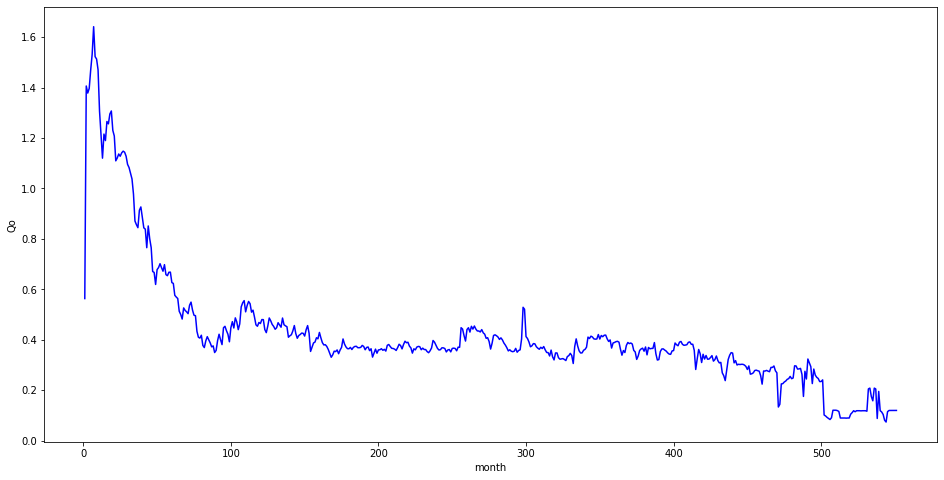

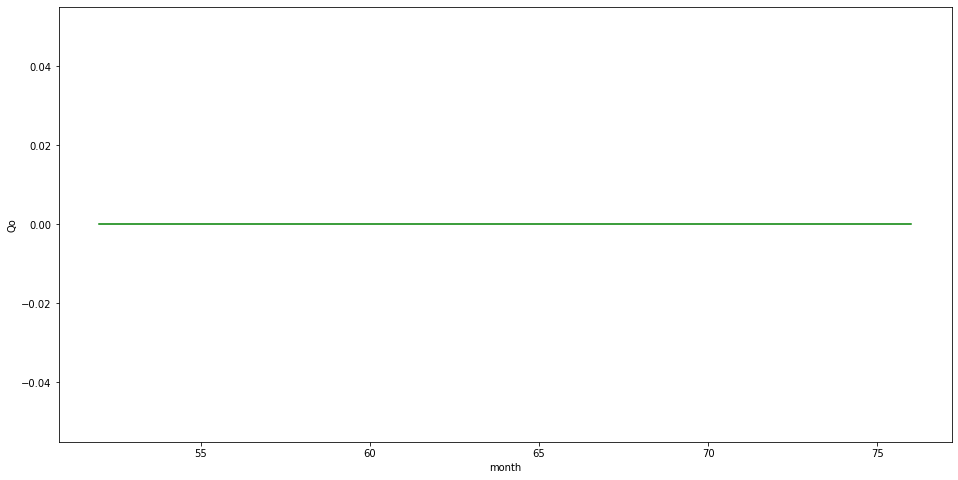

In [88]:
fig4, ax4 = plt.subplots(figsize=(16,8))
ax4.plot(df_sales_pred['month'],df_sales_pred['aceite_Mbd'],color='Blue')
ax4.set_xlabel('month')
ax4.set_ylabel('Qo')
plt.show()

fig5, ax5 = plt.subplots(figsize=(16,8))
ax5.plot(df_sales_pred['month'],df_sales_pred['pred_value'],color='Green')
ax5.set_xlabel('month')
ax5.set_ylabel('Qo')
plt.show()

Segmentar el df por dia de max produccion en adelante

# Change Point Detection

# Binary segmentation method

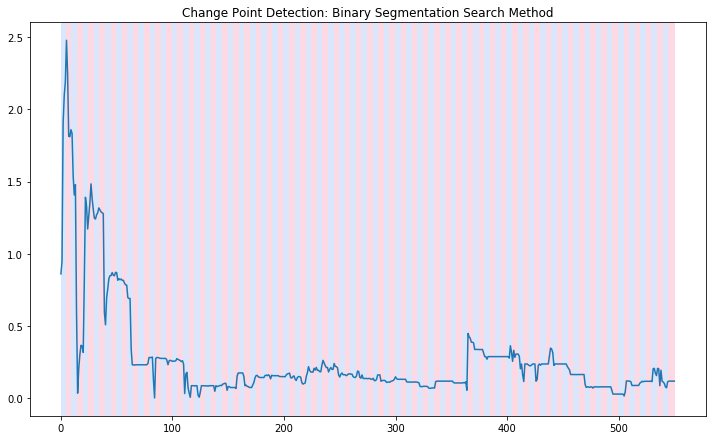

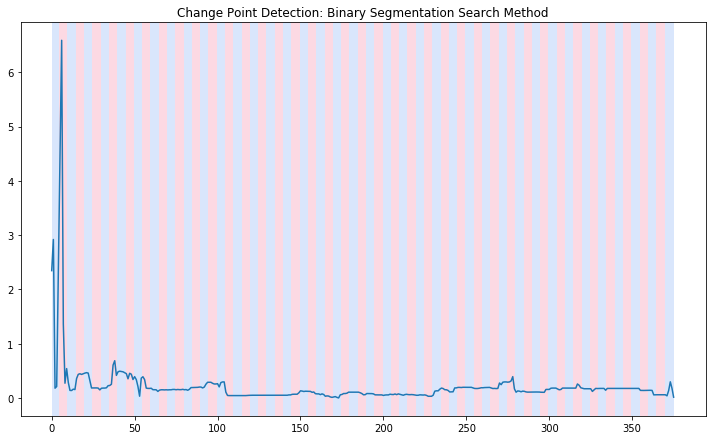

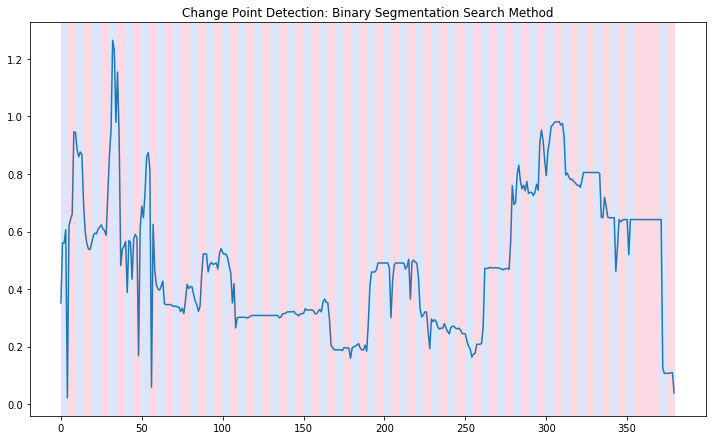

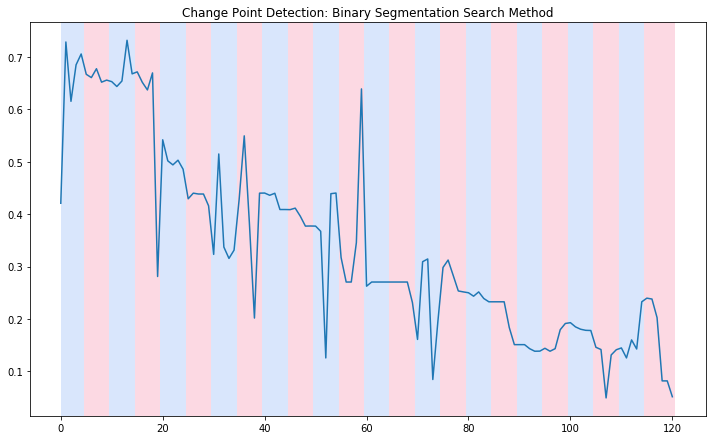

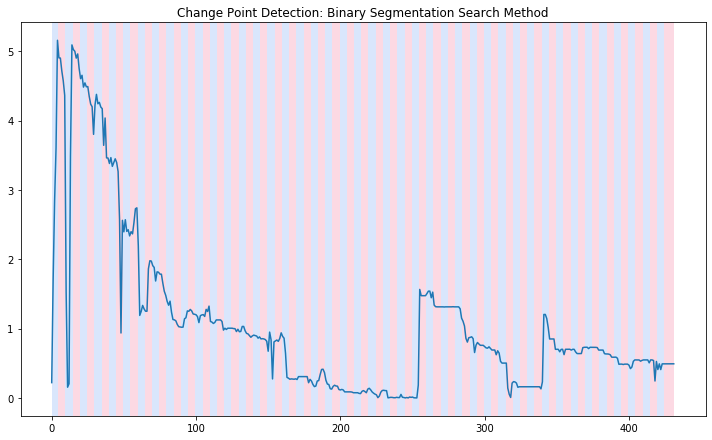

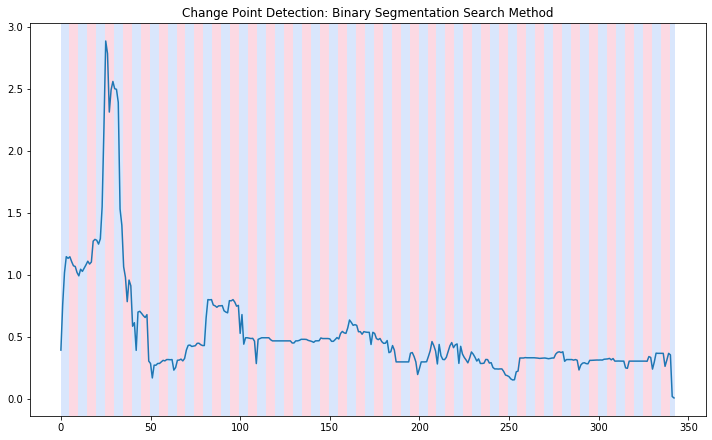

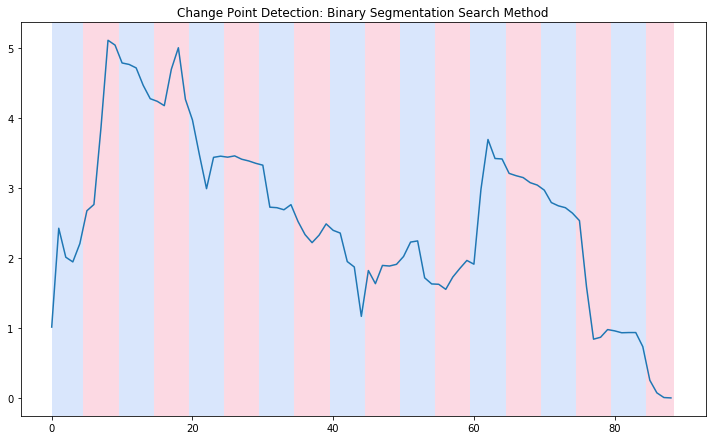

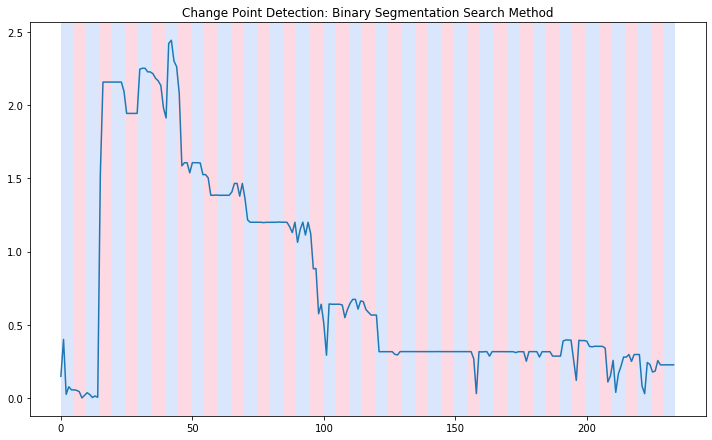

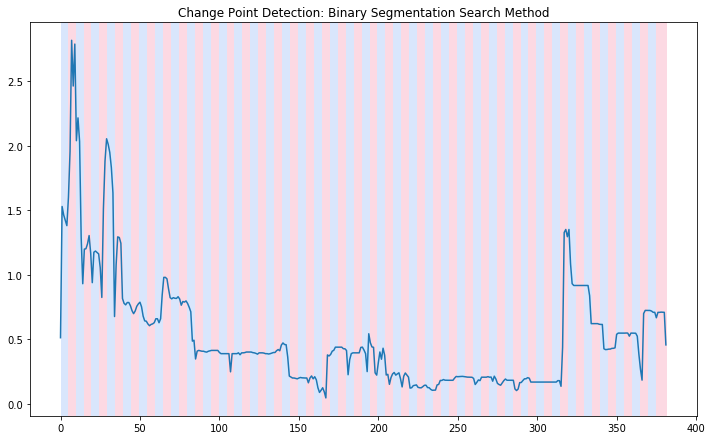

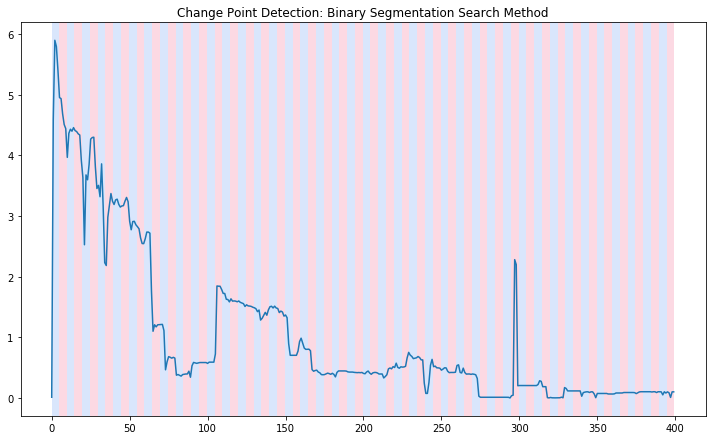

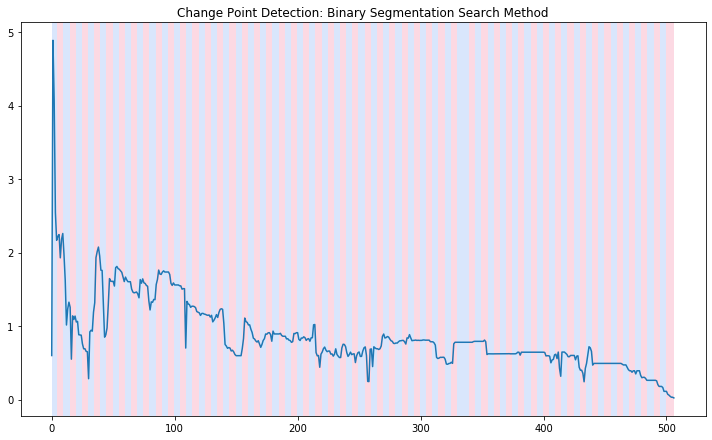

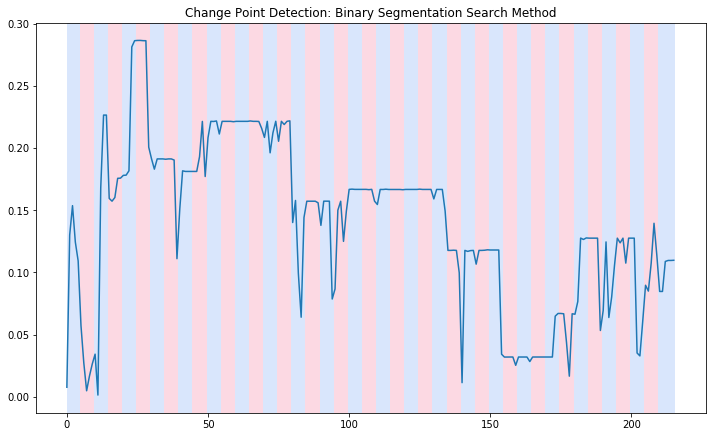

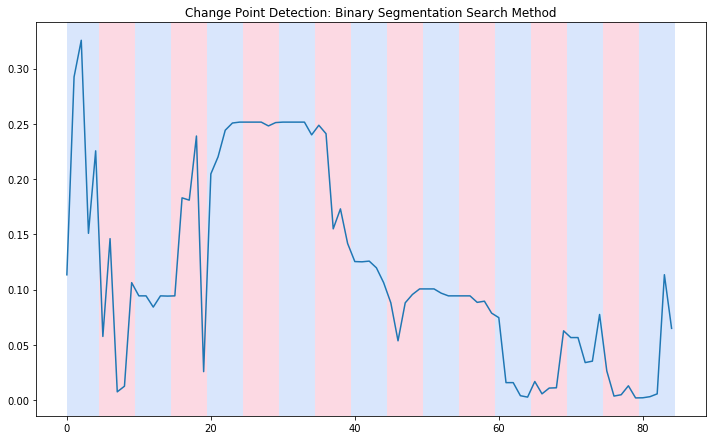

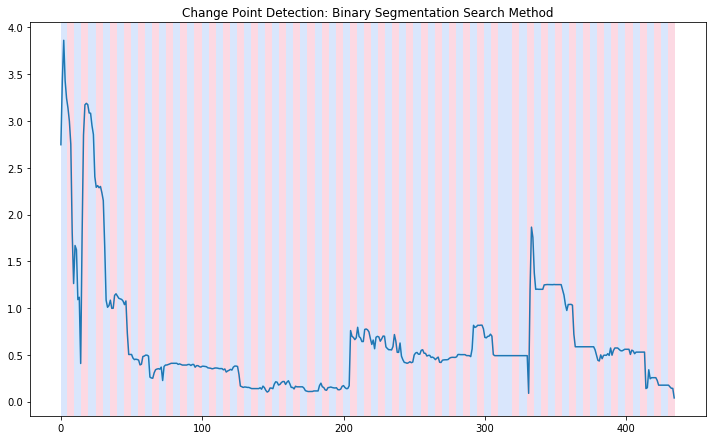

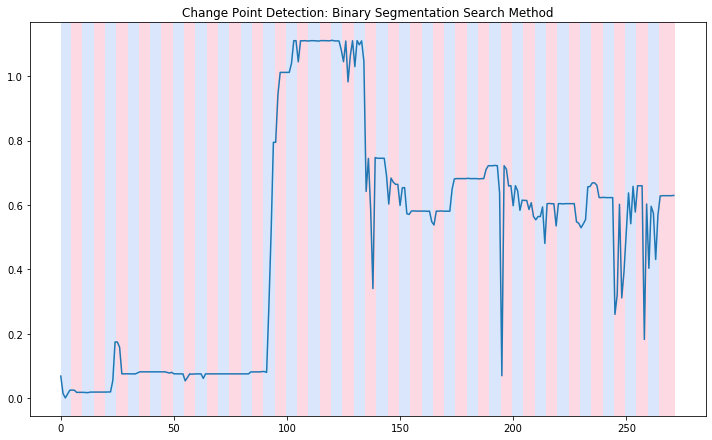

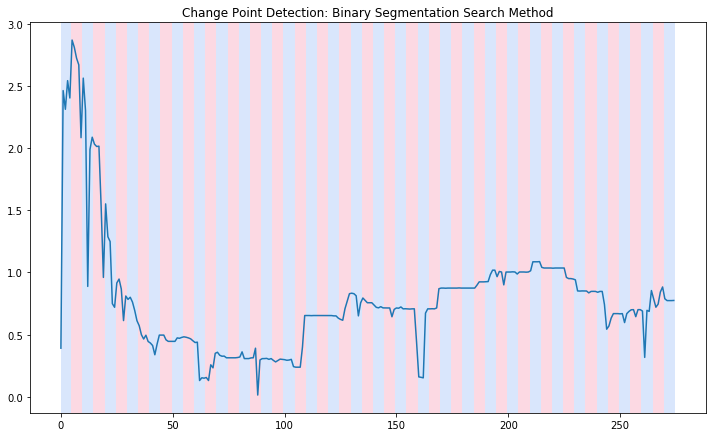

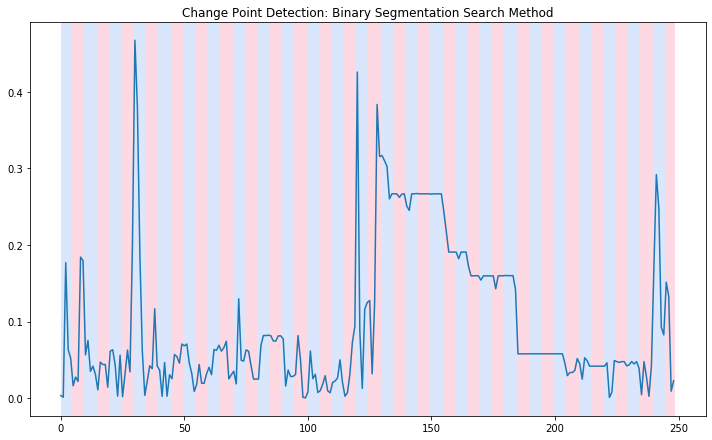

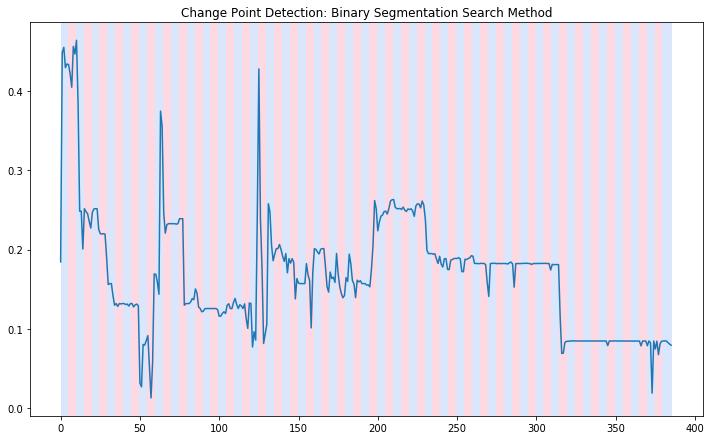

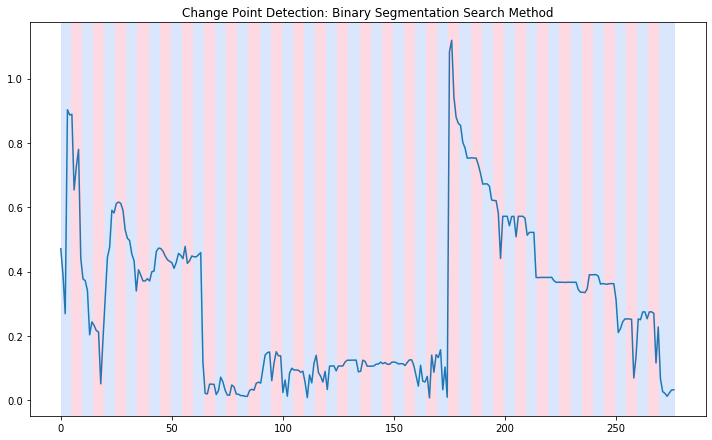

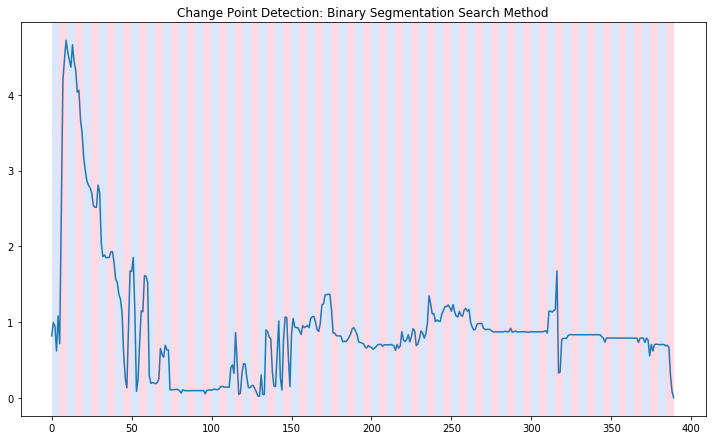

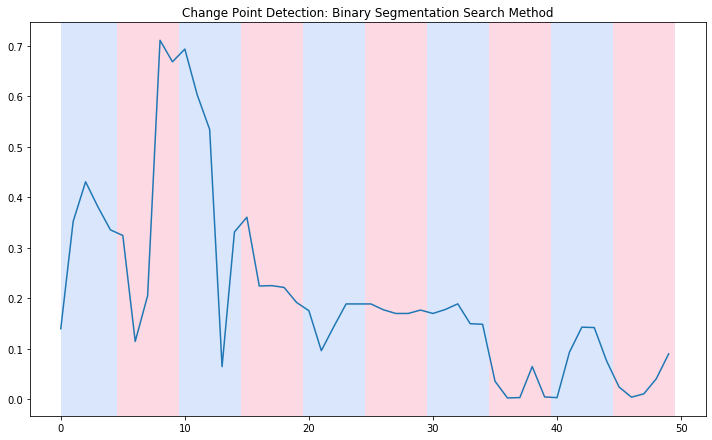

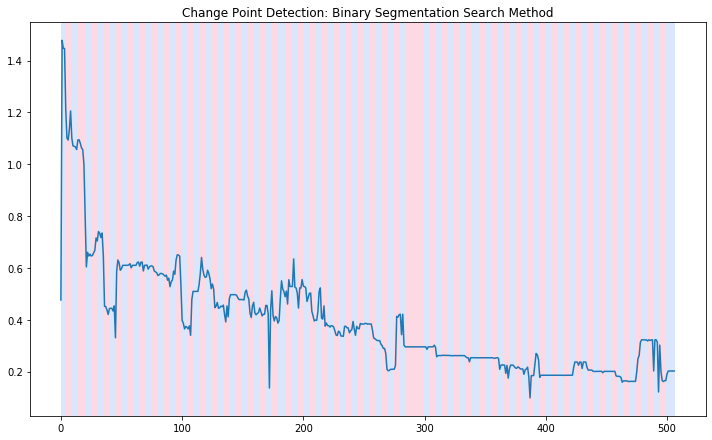

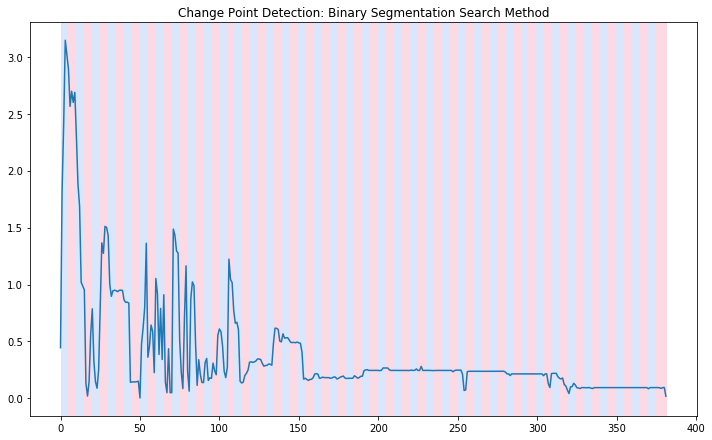

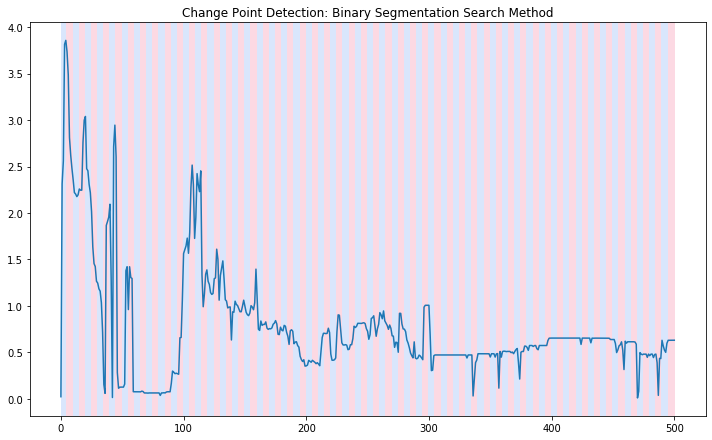

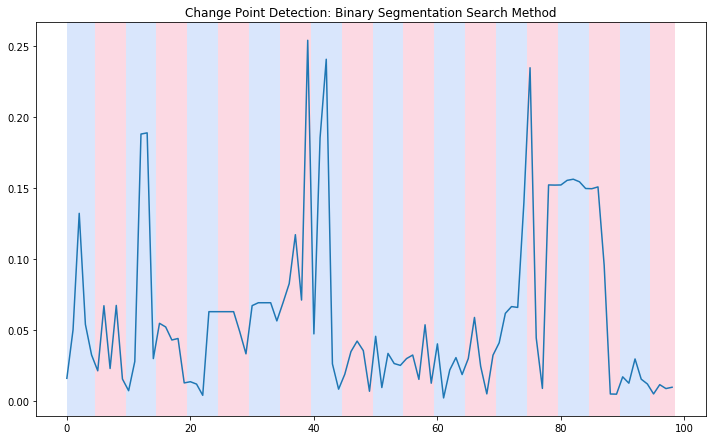

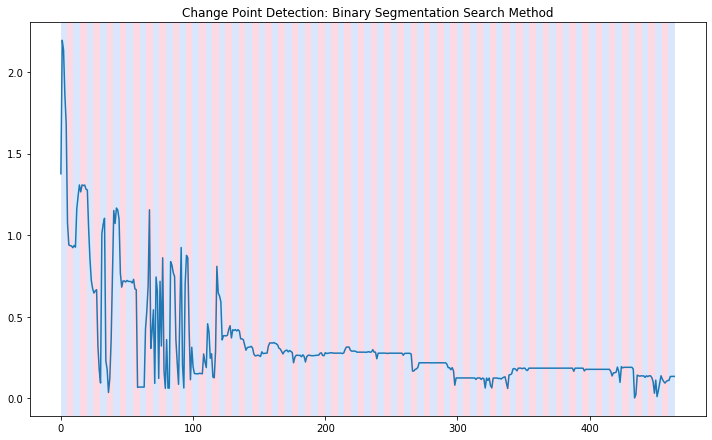

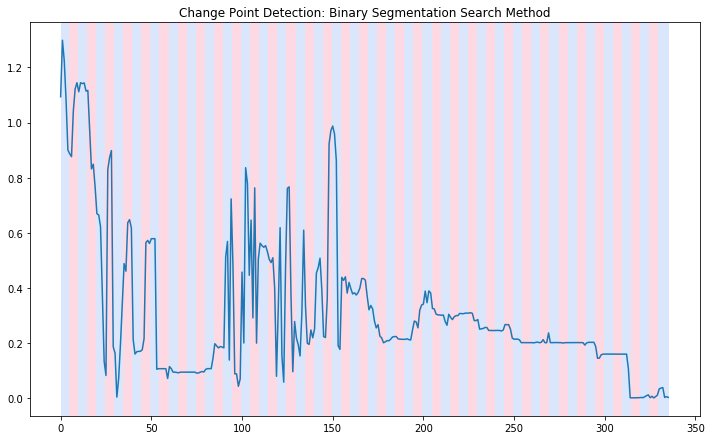

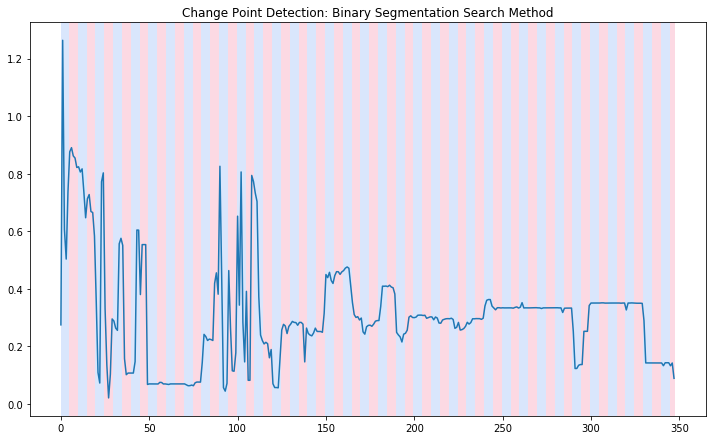

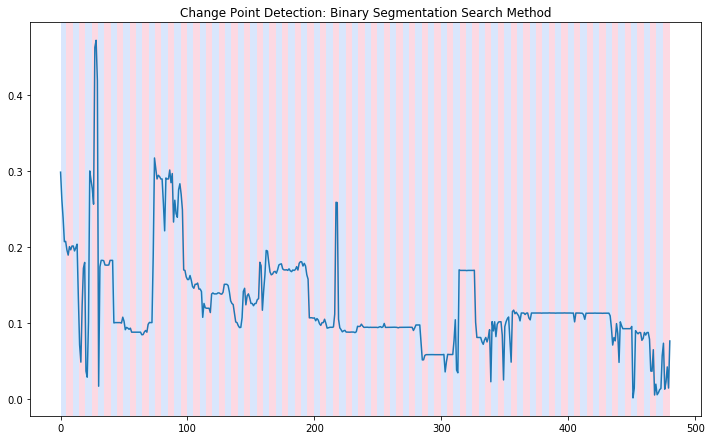

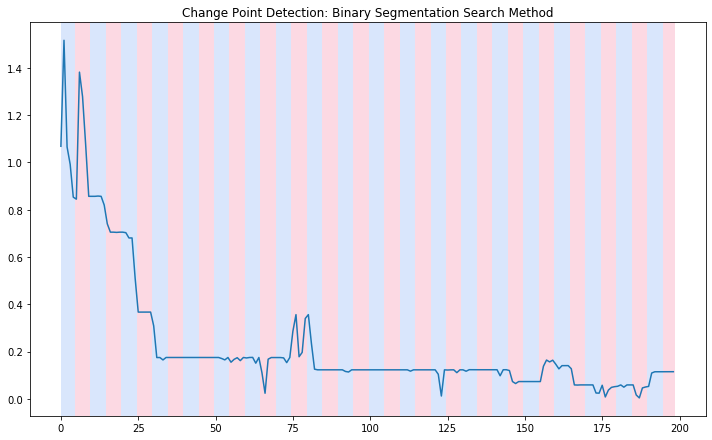

In [89]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l2"  
        algo = rpt.Binseg(model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000_000)
        # show results
        rpt.show.display(points, my_bkps, figsize=(10, 6),scalex=False)
        plt.title('Change Point Detection: Binary Segmentation Search Method')
        plt.show()

# Pelt search method

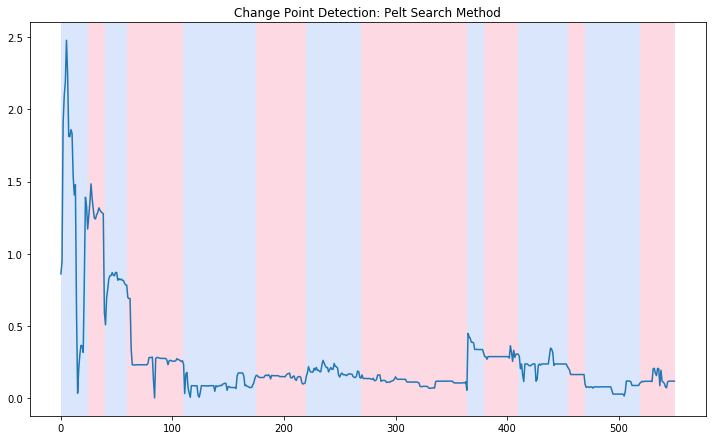

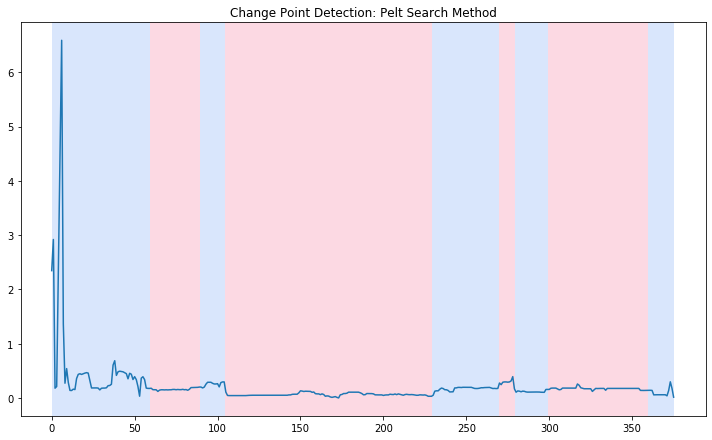

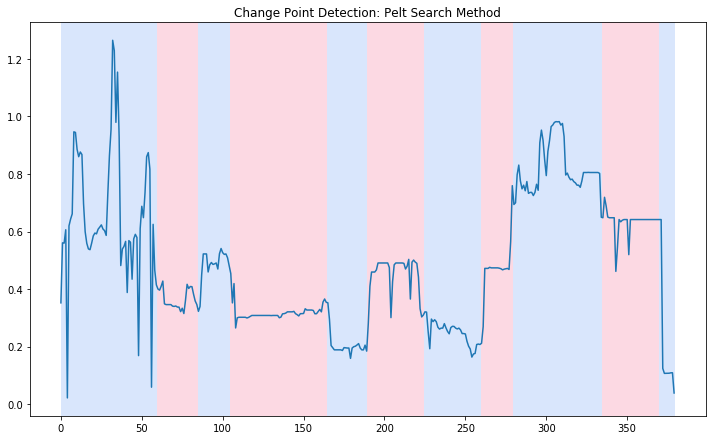

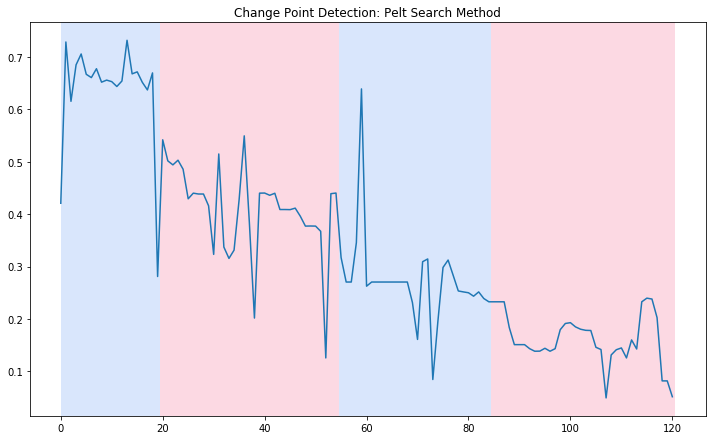

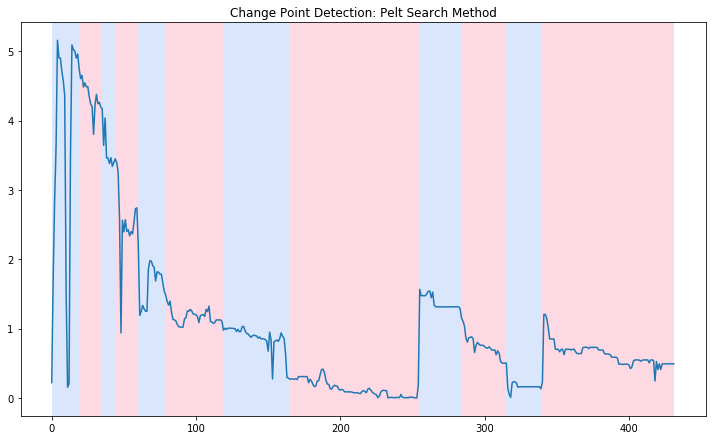

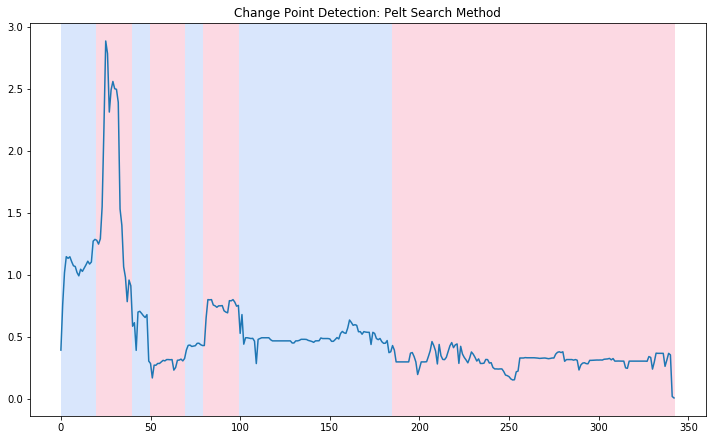

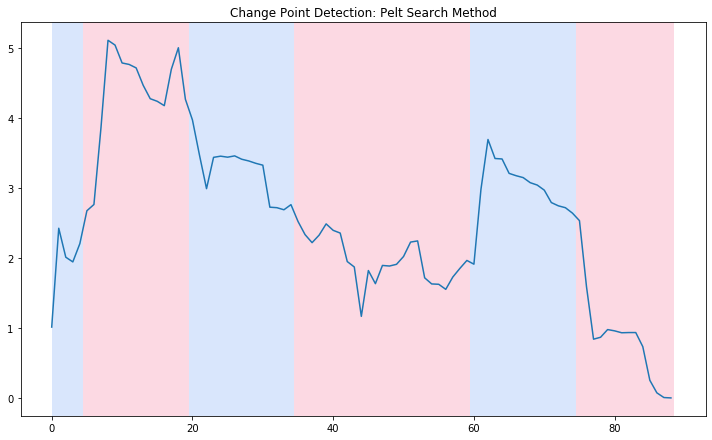

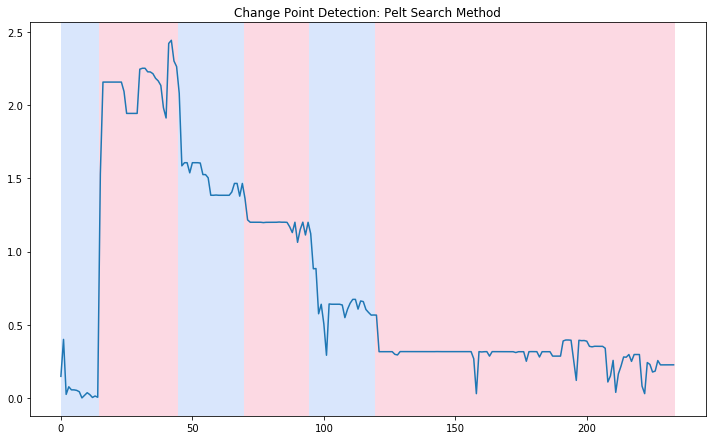

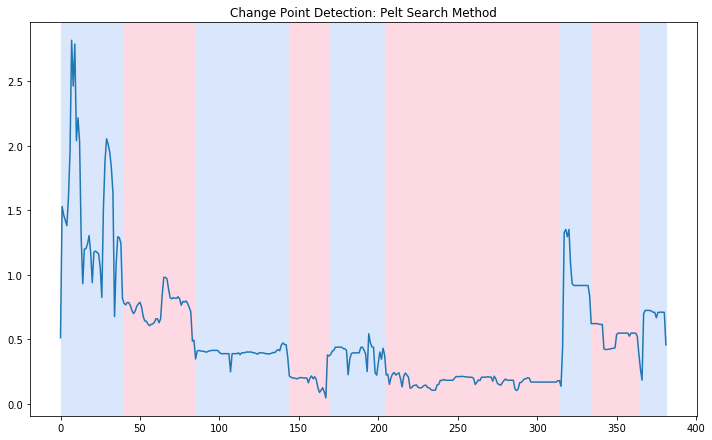

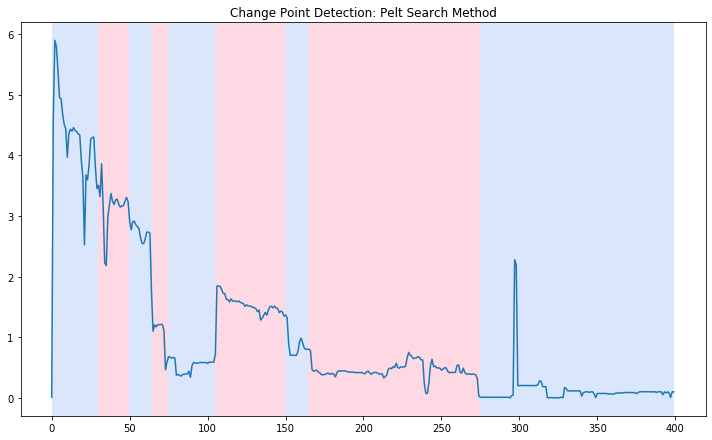

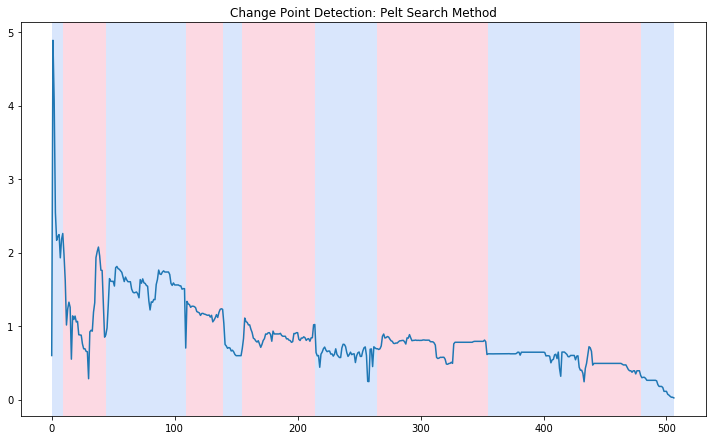

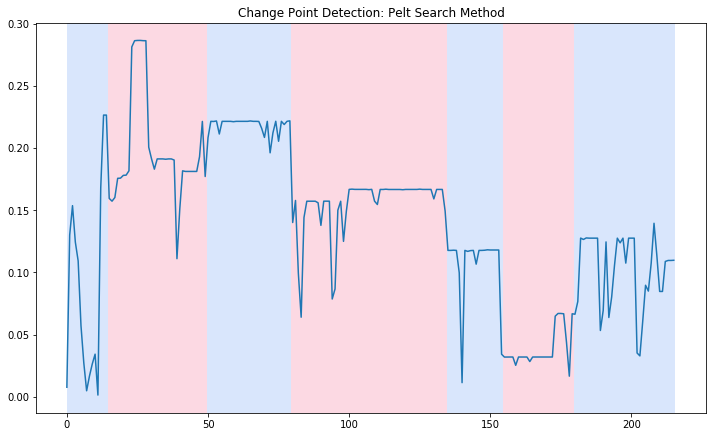

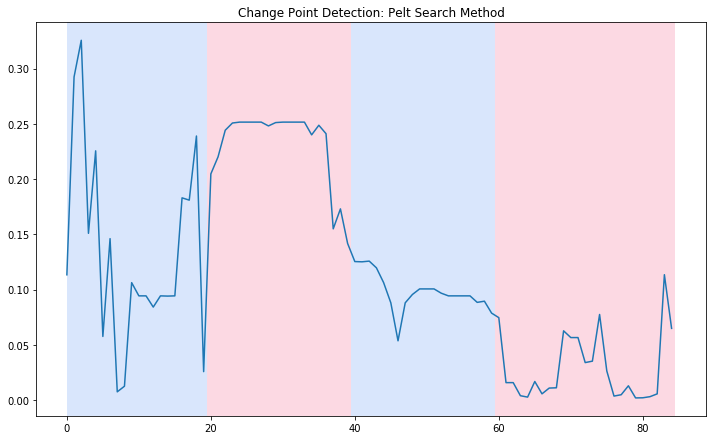

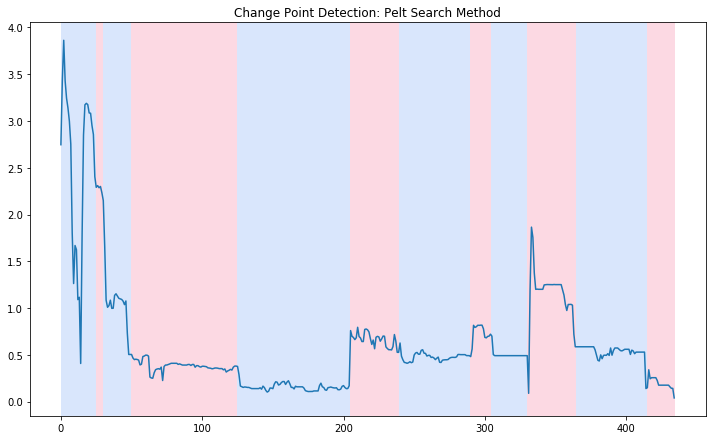

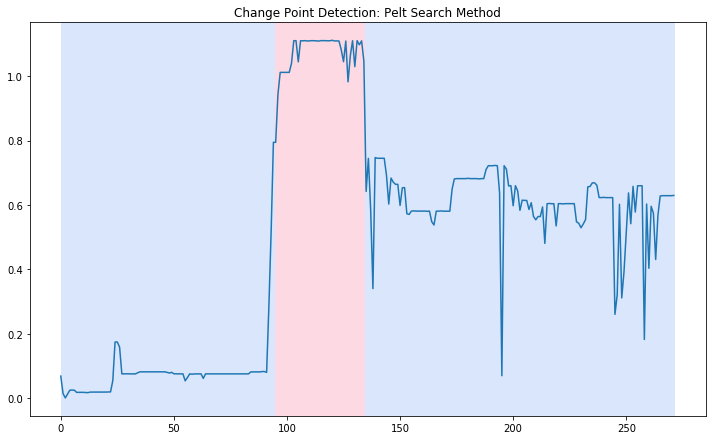

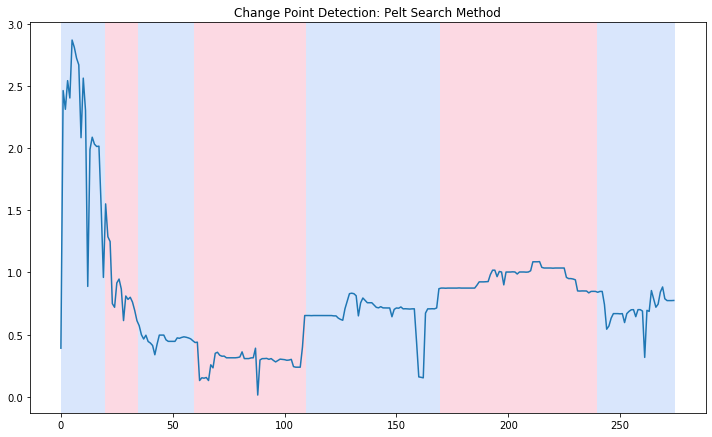

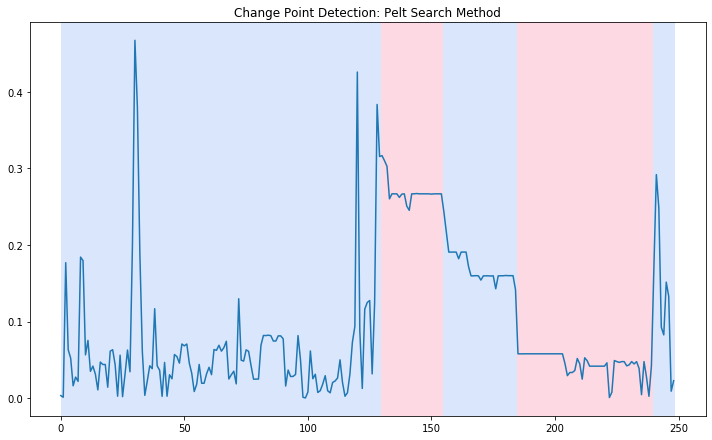

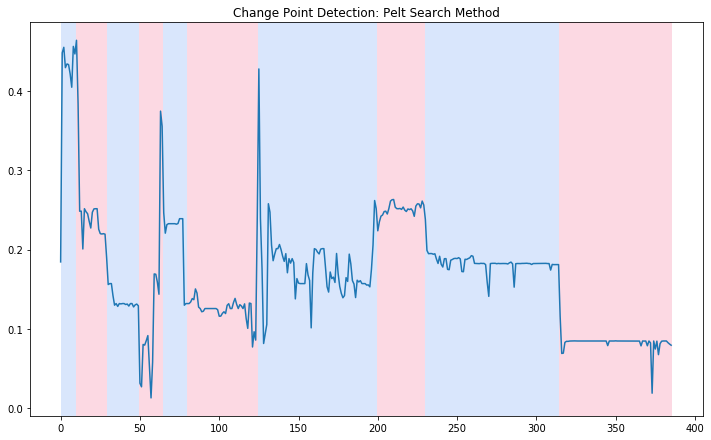

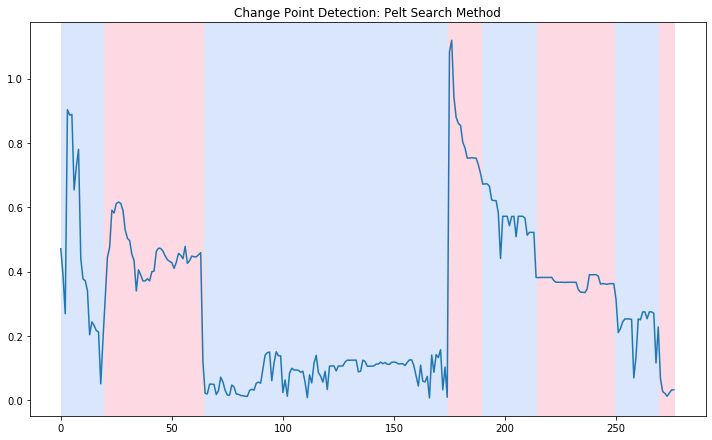

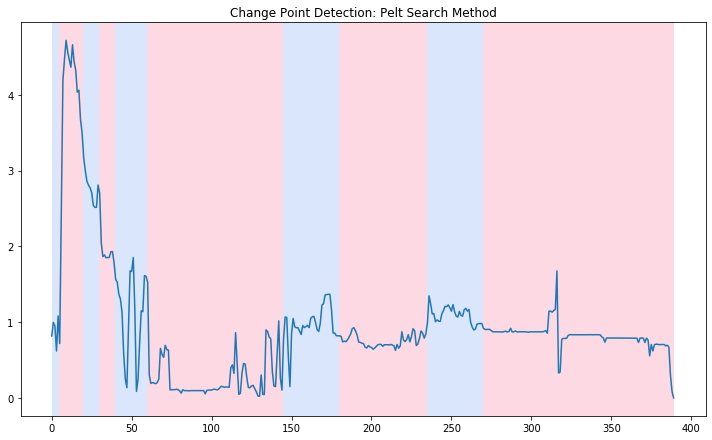

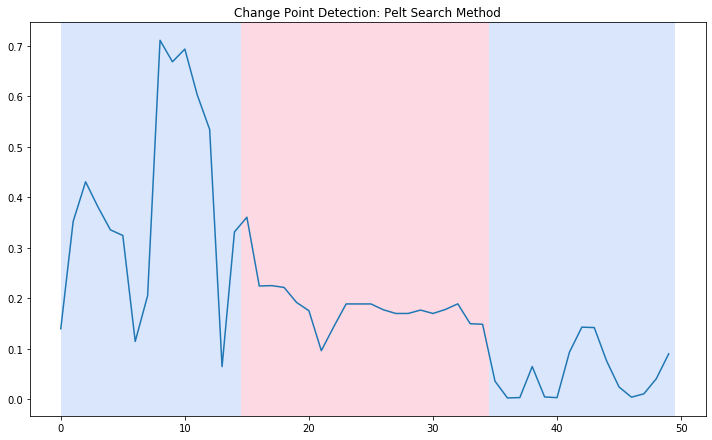

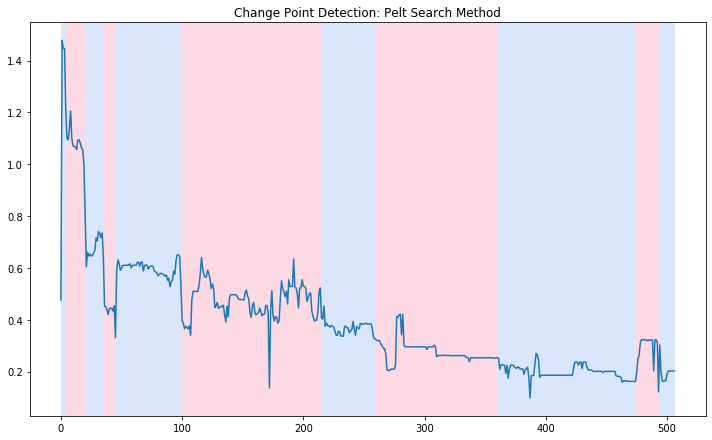

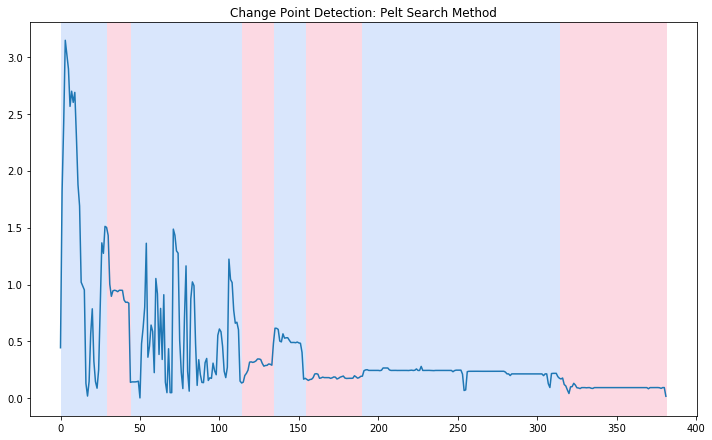

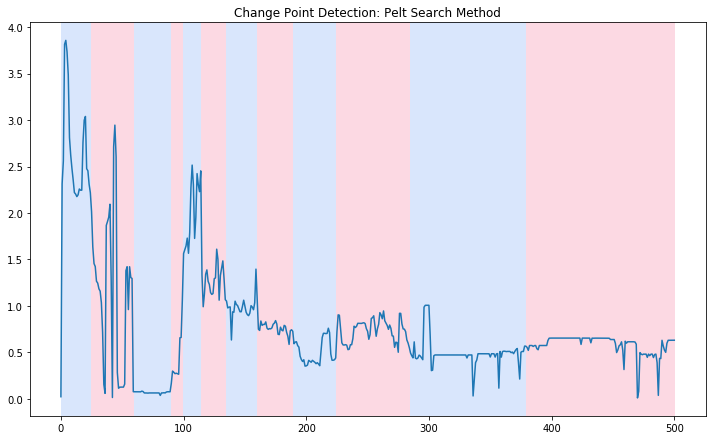

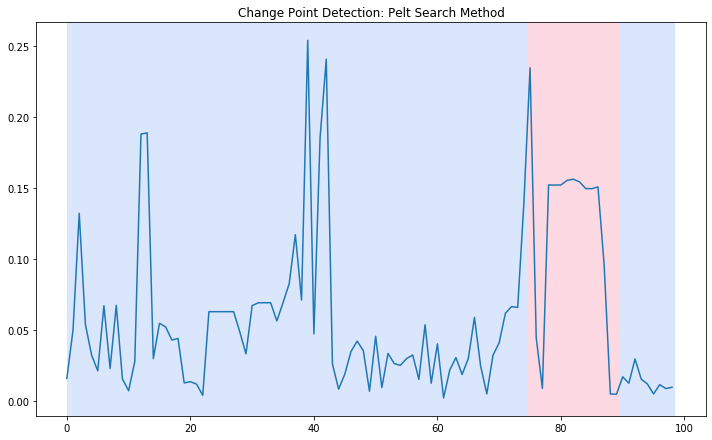

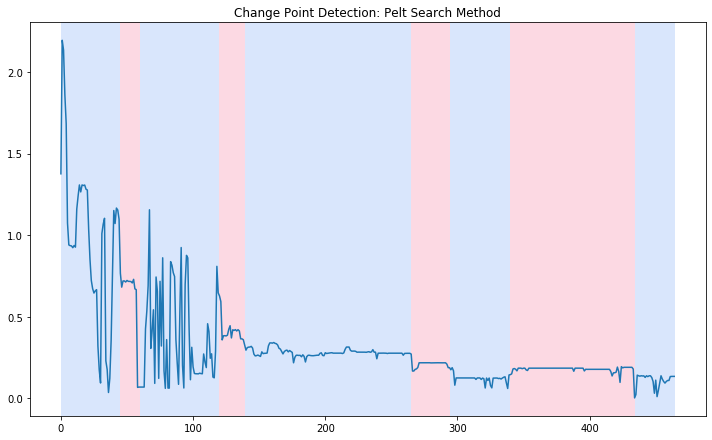

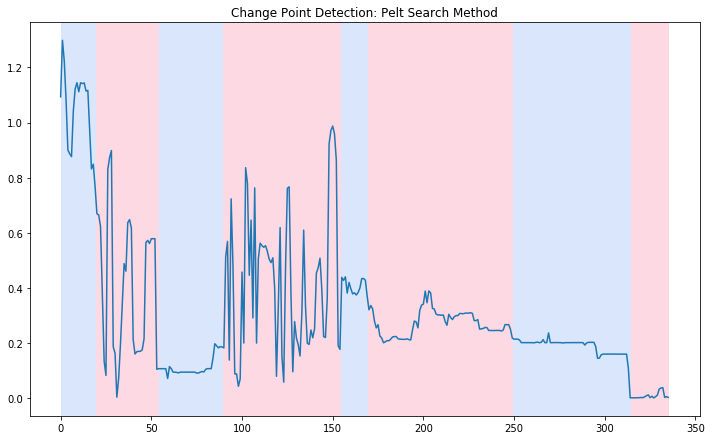

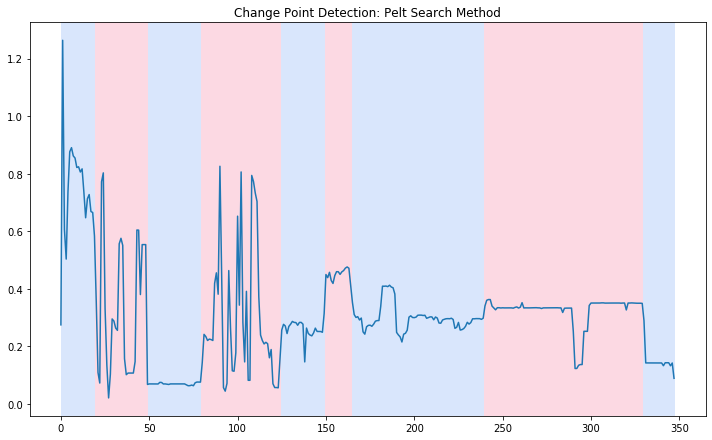

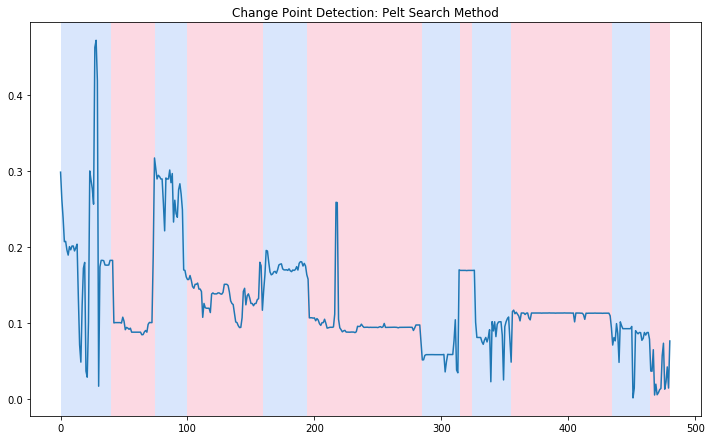

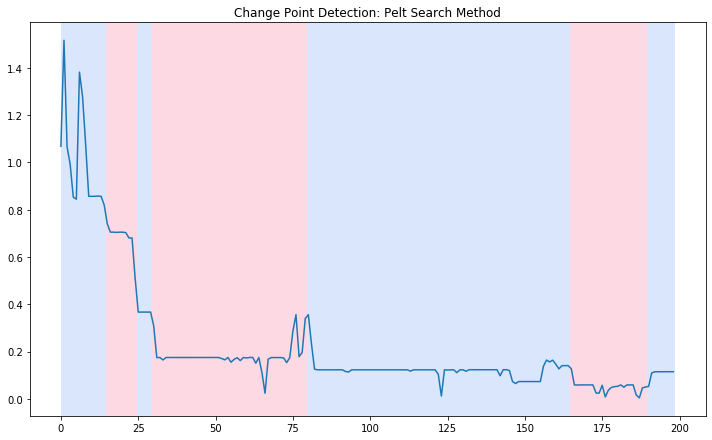

In [96]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model="rbf"
        algo = rpt.Pelt(model=model).fit(points)
        result = algo.predict(pen=4)
        rpt.display(points, result, figsize=(10, 6))
        plt.title('Change Point Detection: Pelt Search Method')
        plt.show()

# Dynamic programming search method

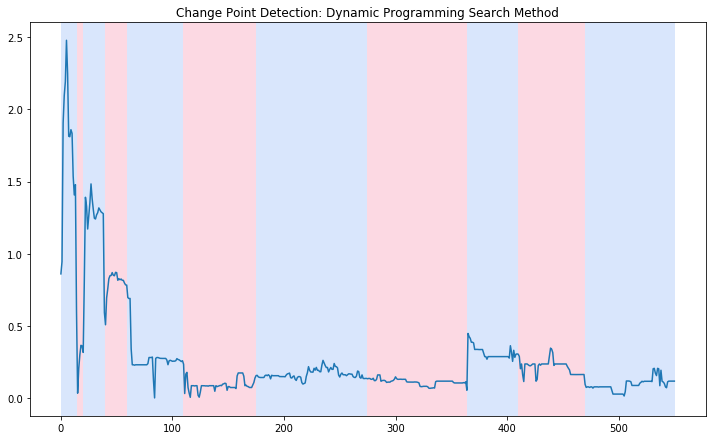

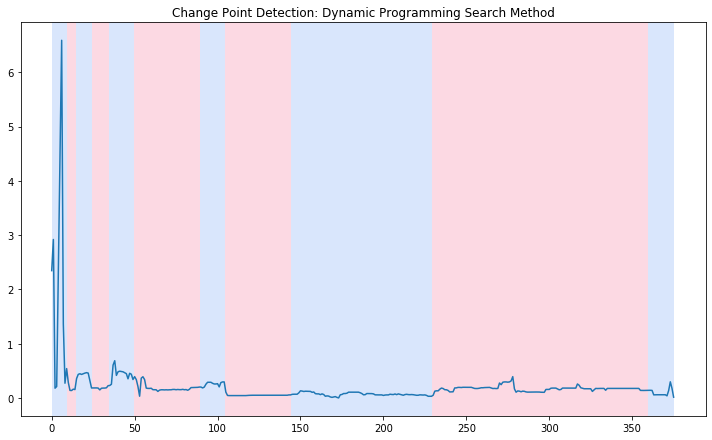

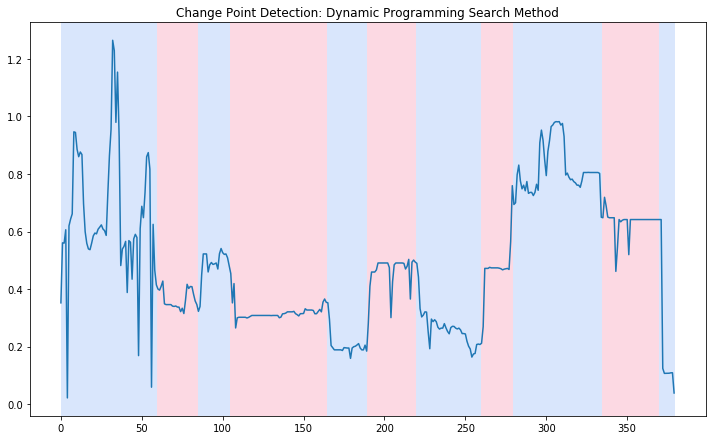

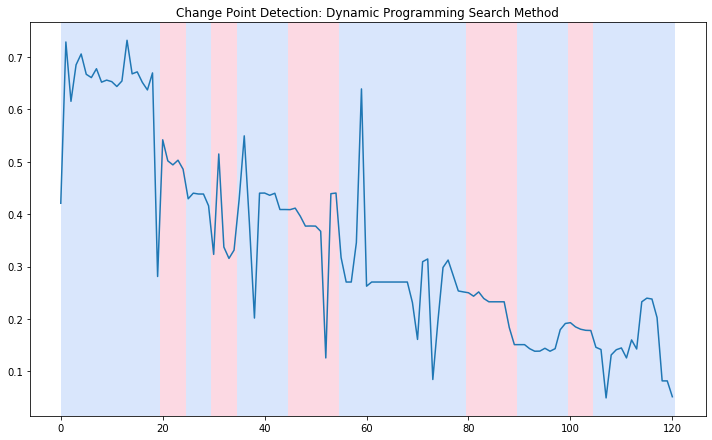

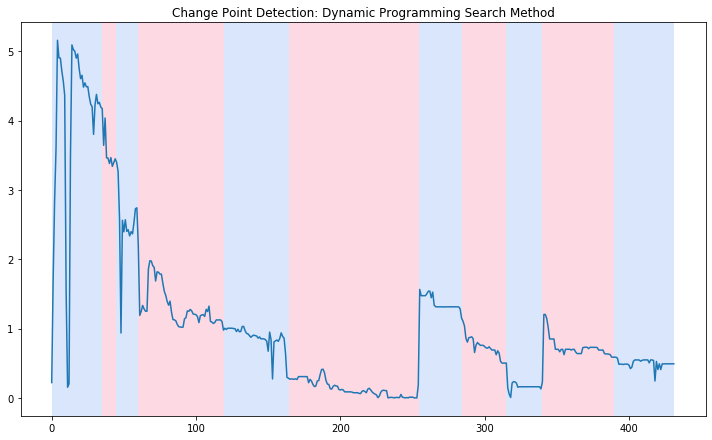

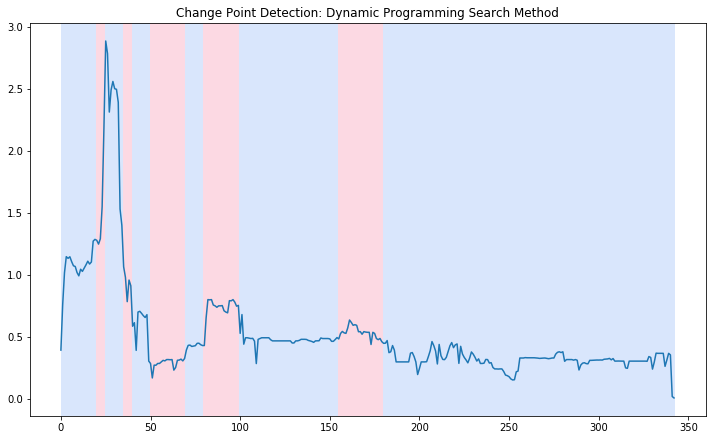

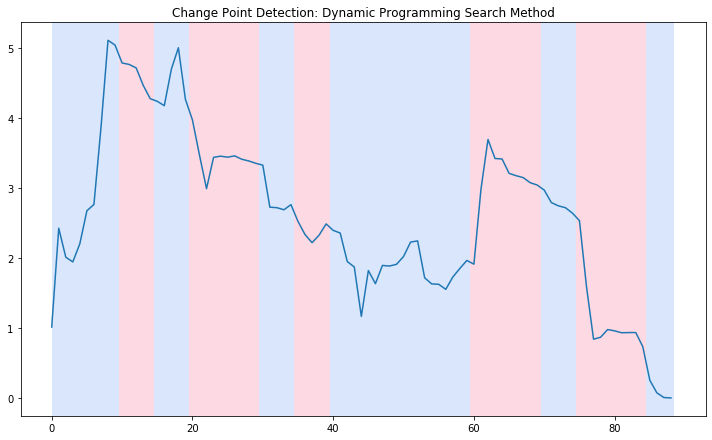

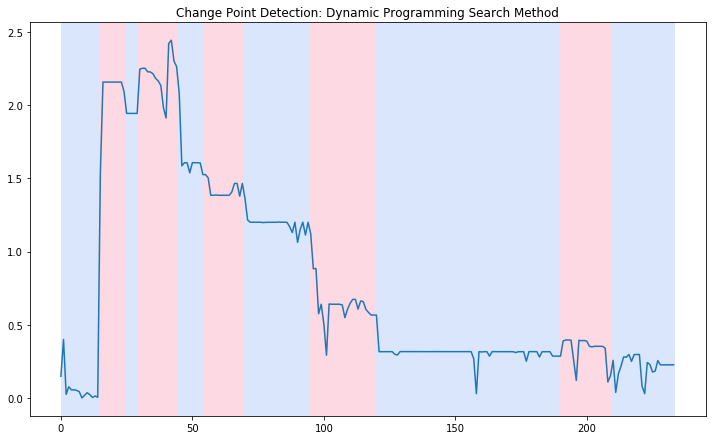

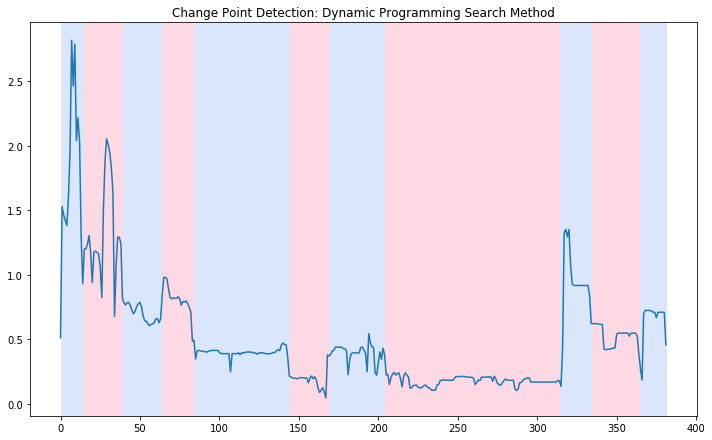

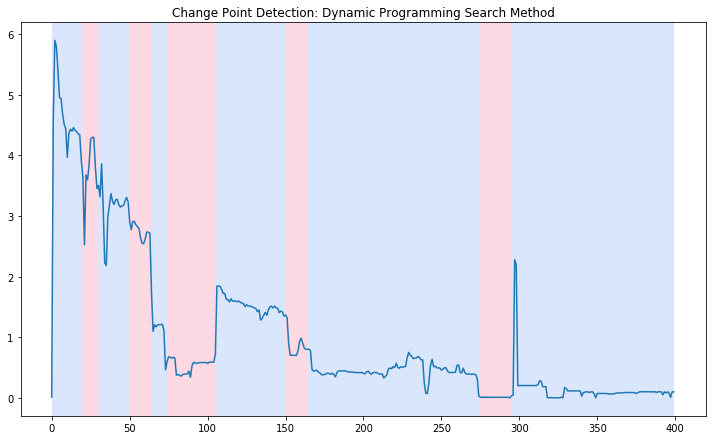

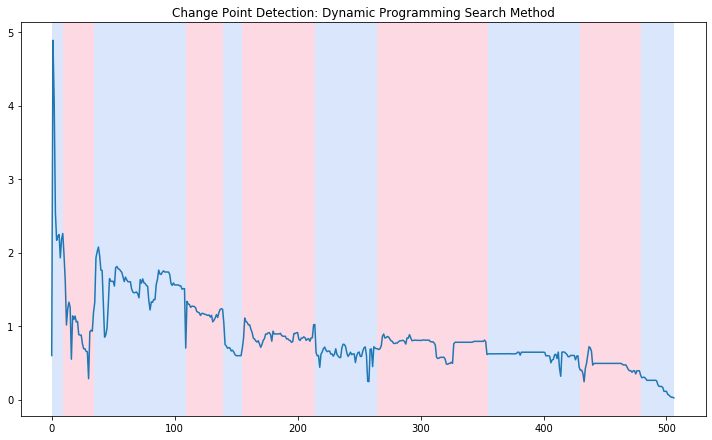

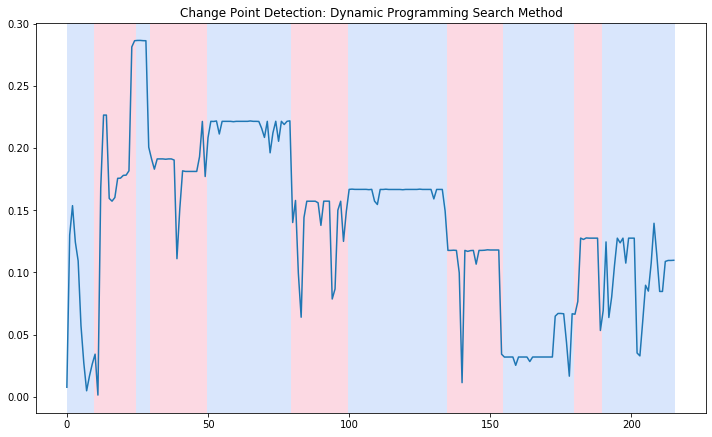

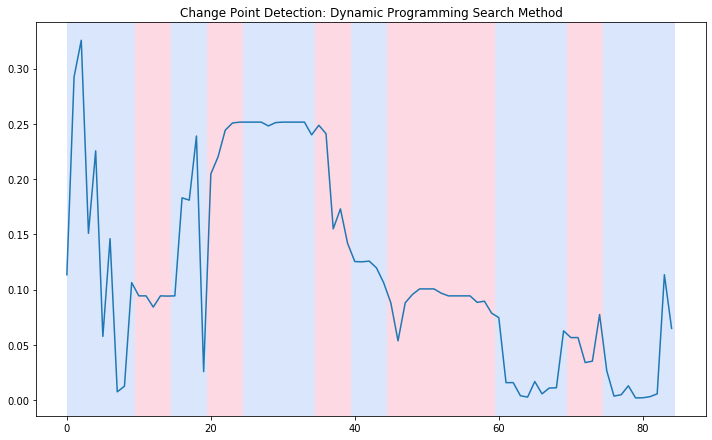

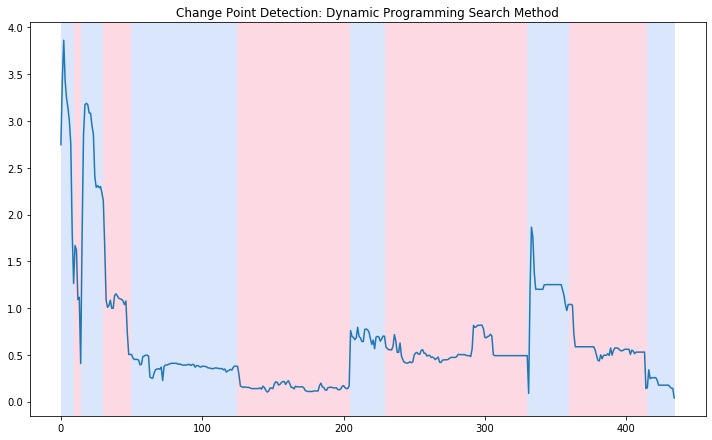

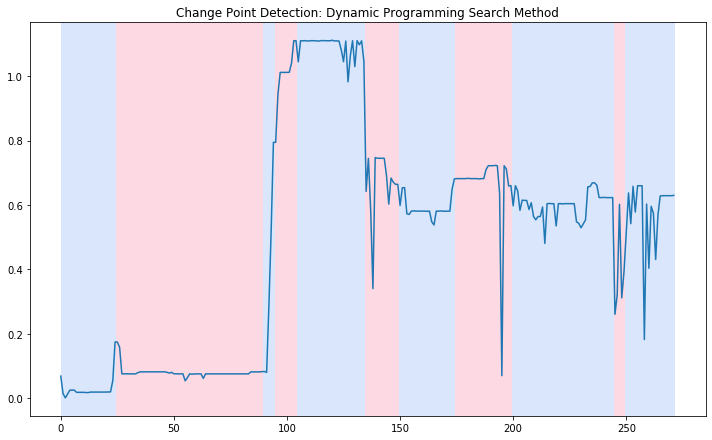

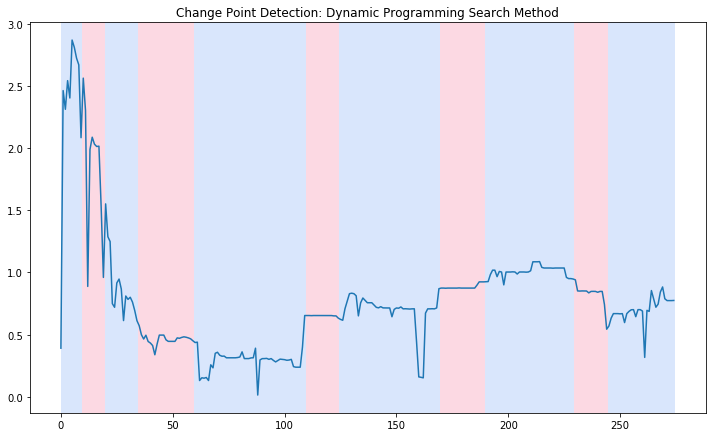

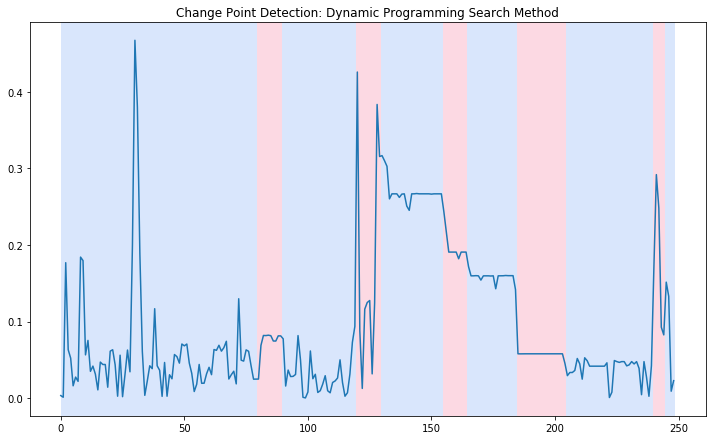

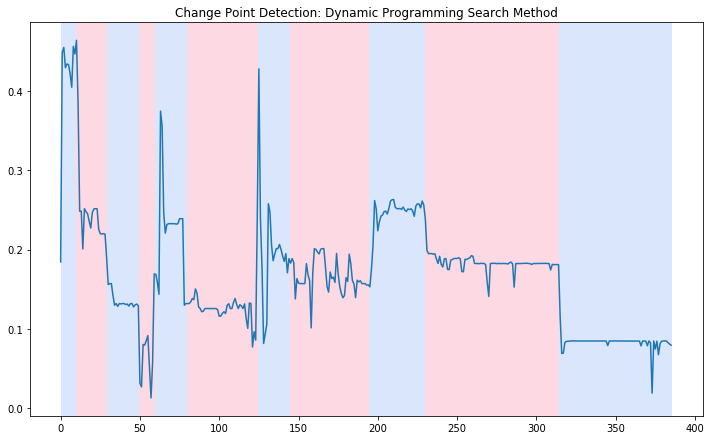

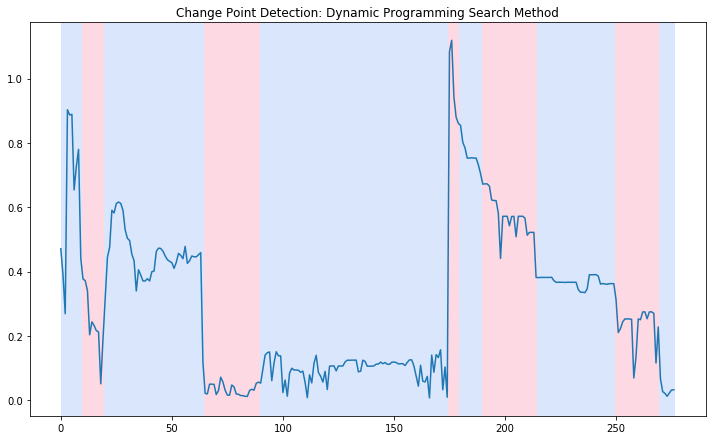

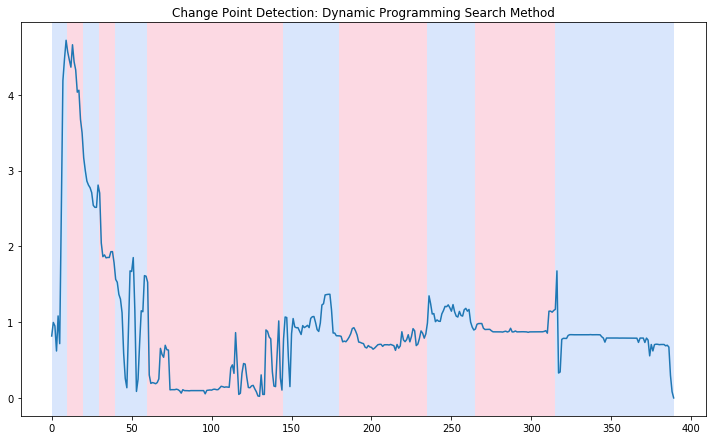

AssertionError: No admissible last breakpoints found.             start, end: (0,50), n_bkps: 10.

In [91]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l1"  
        algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
        my_bkps = algo.predict(n_bkps=10)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Dynamic Programming Search Method')
        plt.show()

# Window-based search method

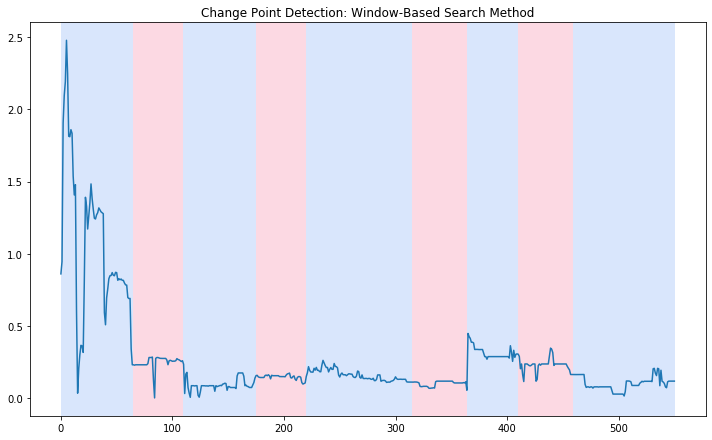

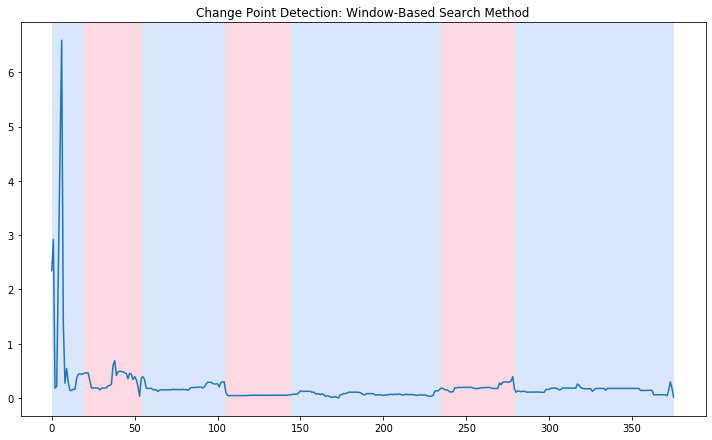

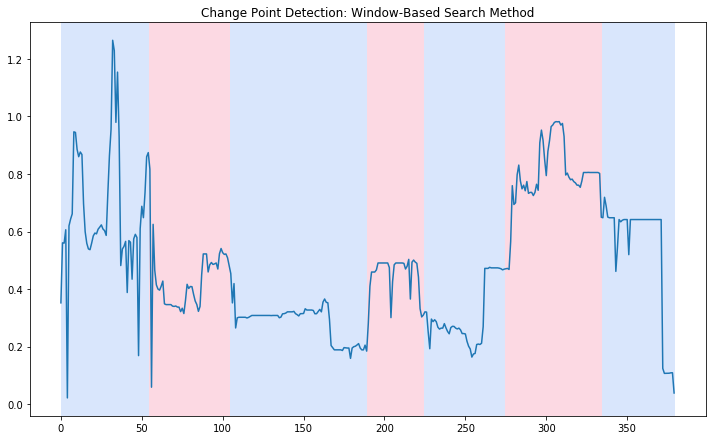

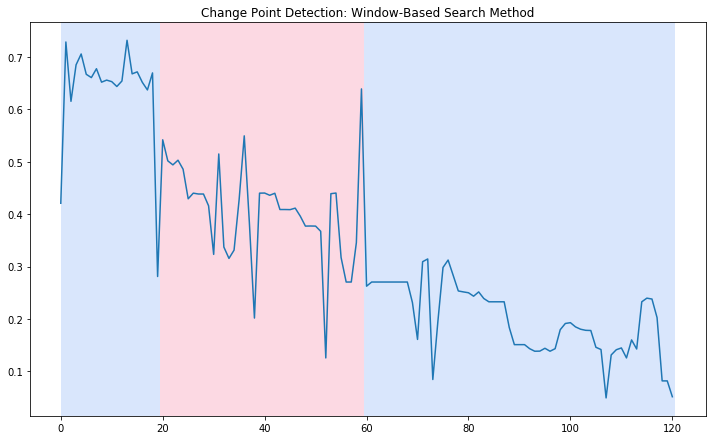

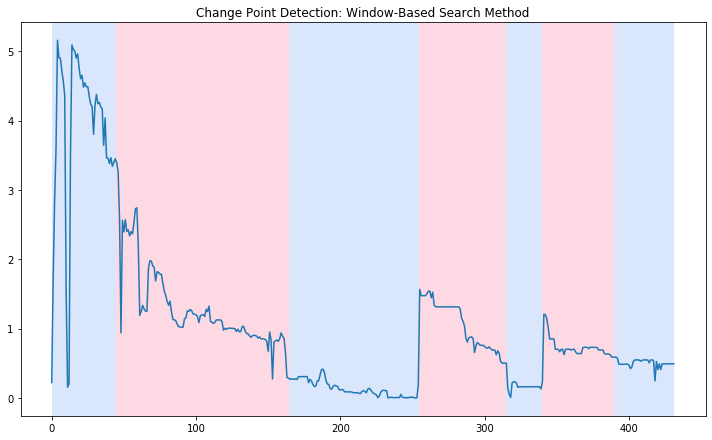

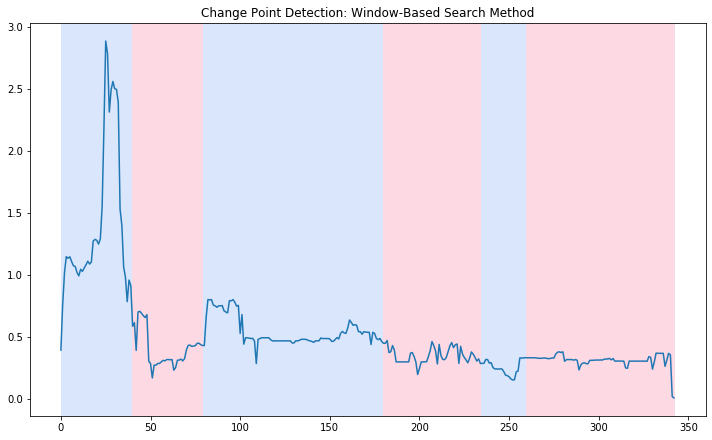

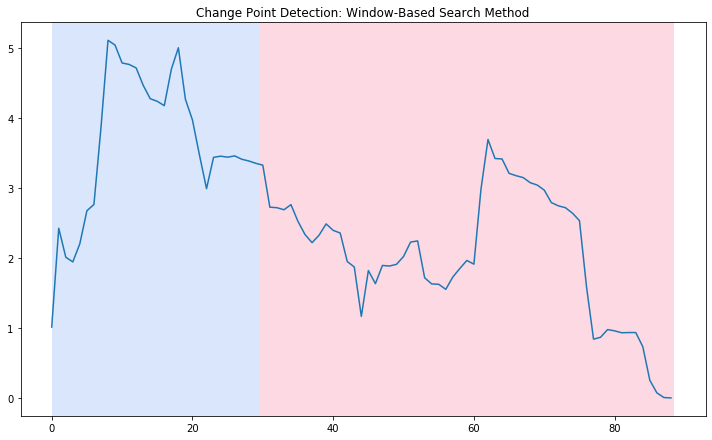

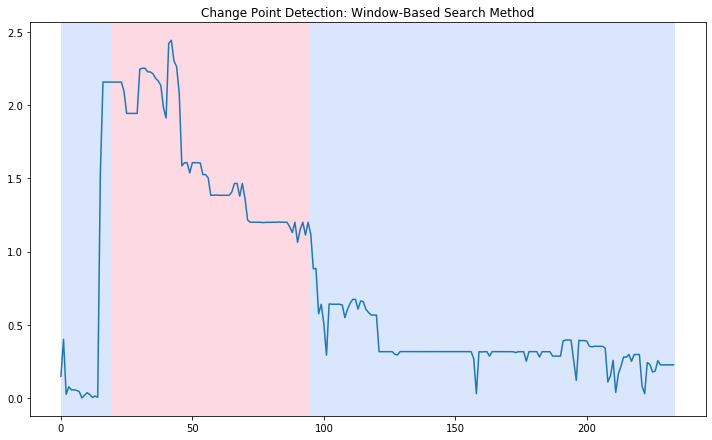

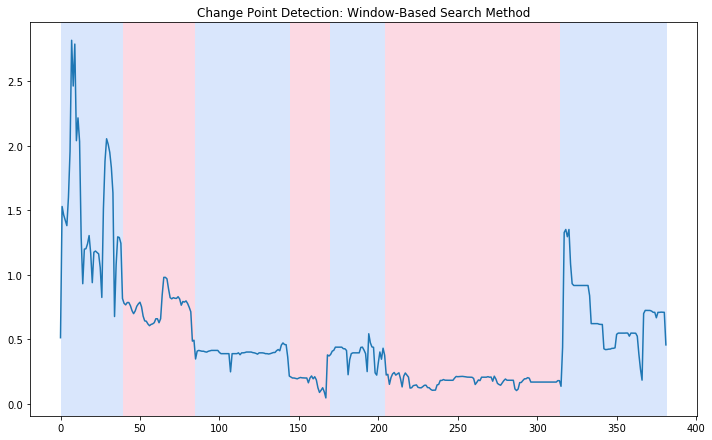

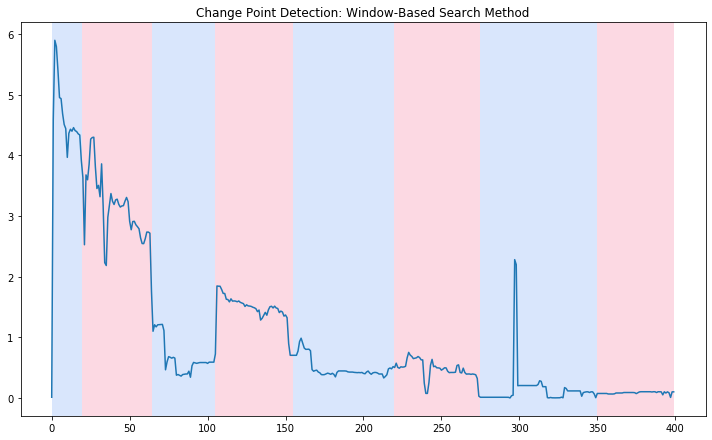

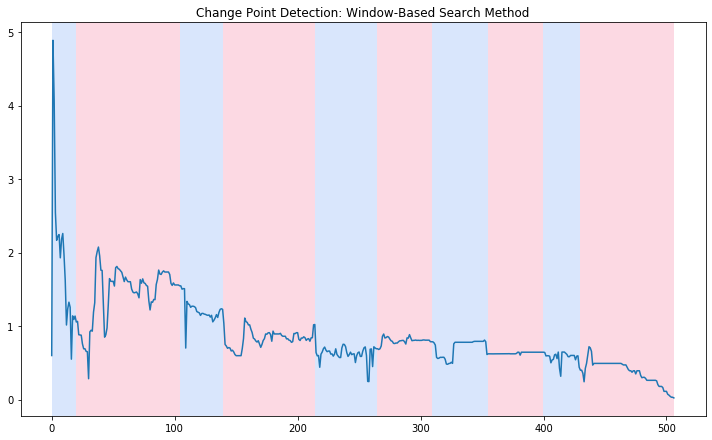

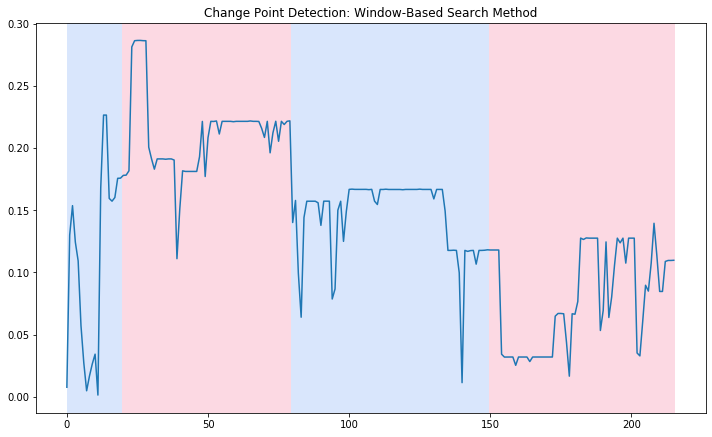

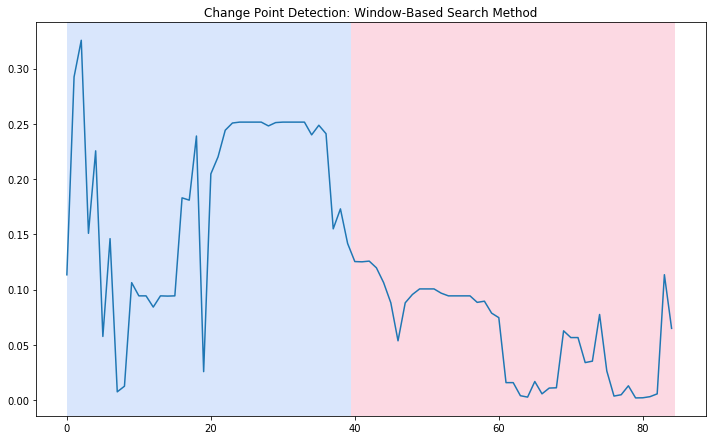

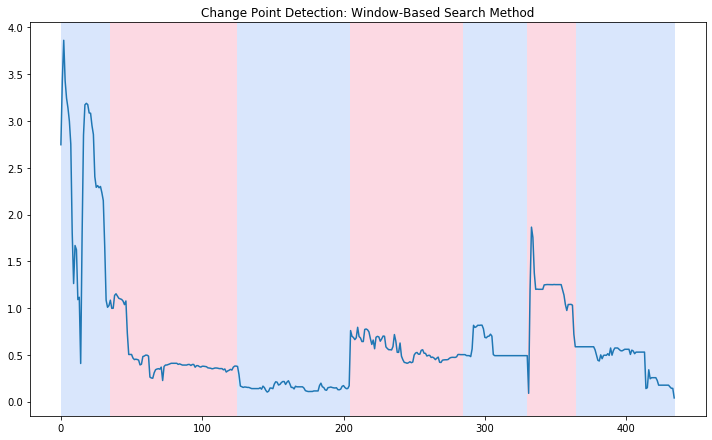

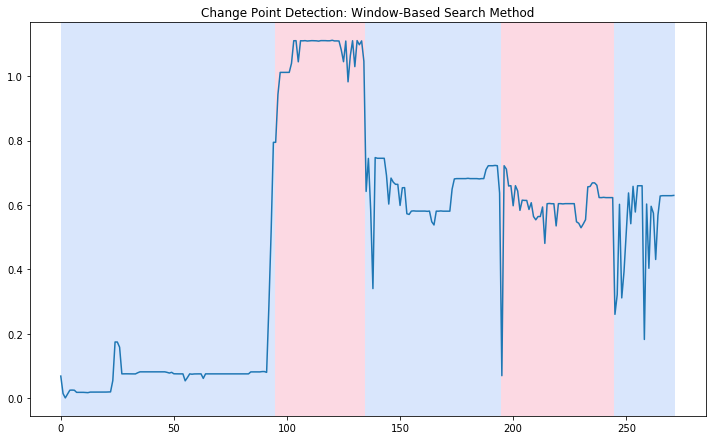

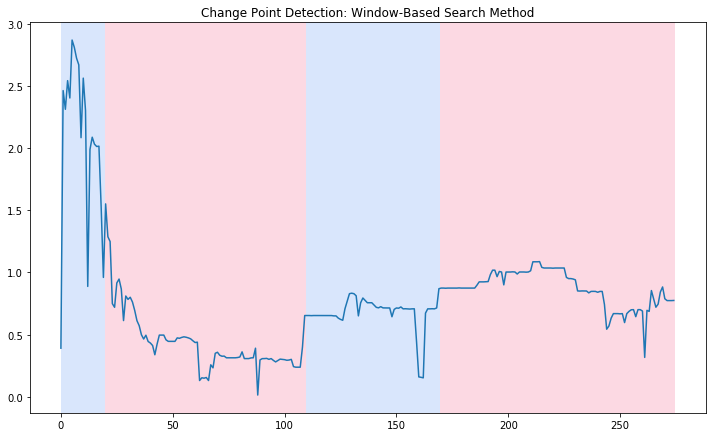

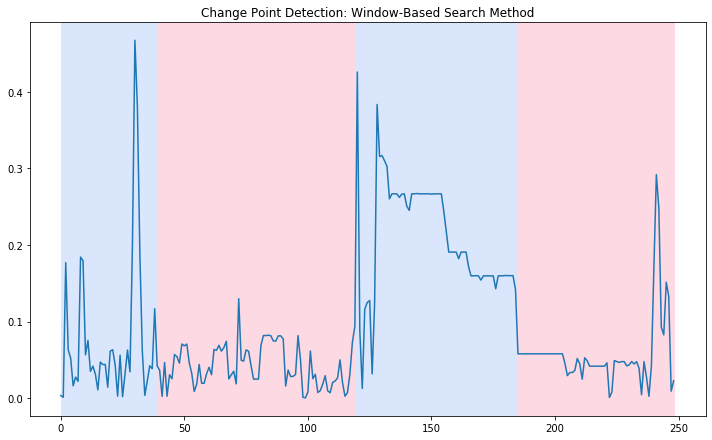

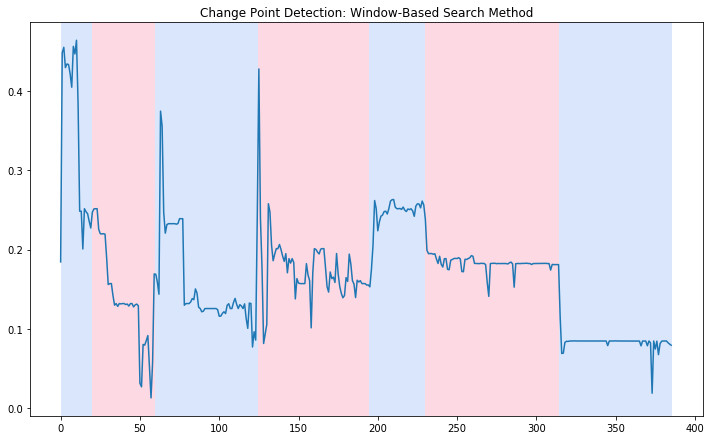

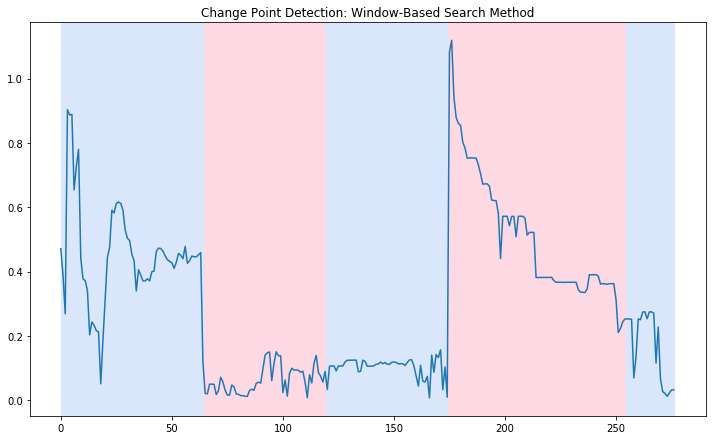

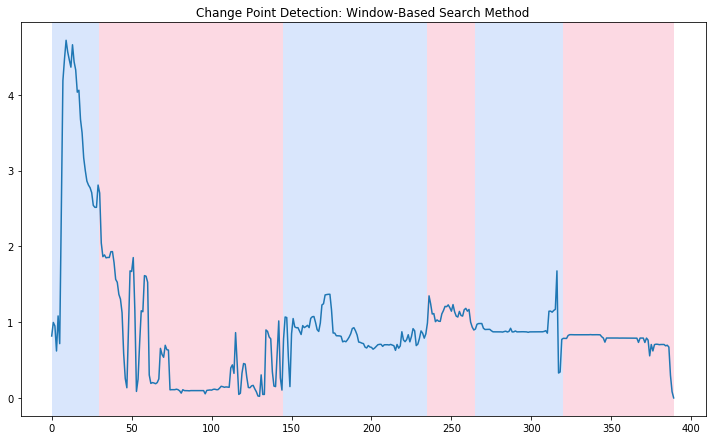

ValueError: not enough values to unpack (expected 2, got 0)

In [95]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)
        
        model = "l2"  
        algo = rpt.Window(width=40, model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Window-Based Search Method')
        plt.show()

In [ ]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    global z_score
    global outliers
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return z_score

In [ ]:
score=[]
def outlier_filter(data):
    global score
    global outliers
    threshold=3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    
    for y in data:
        z = (y - mean_1)/std_1 
        score.append(z)
    return score

In [ ]:
df=campo
outliers=outlier_filter(df.aceite_Mbd)


In [ ]:
display(score) 

In [ ]:
display(fechas)

In [ ]:
for mes in fechas:
    x=calendar.monthrange(mes[0],mes[1])
    display(x)

In [ ]:
mx_stats=pd.read_csv(r'C:\Users\elias\Downloads\Well_production/pozos.csv',
                         #index_col=1,
                         parse_dates=True,
                         #encoding='utf-8',
                         engine='python',
                         low_memory=True)

In [ ]:
display(mx_stats.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(mx_stats.fecha,mx_stats.aceite_Mbd)
ax.set_xlabel('Pozo')
ax.set_xticklabels(labels=mx_stats.pozo,rotation=90)
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()